In [1]:
import pandas as pd
import re
import operator
import calendar
import urllib.request, urllib.error, urllib.parse
from datetime import datetime,timedelta
from bs4 import BeautifulSoup
# Get Tourneys
fileName=('BURecordBook.txt')
tourneys=[]
teamSet=set()
with open(fileName, 'r', encoding='utf-8') as f:
    read_data = f.read()
    rows=read_data.split('\n')
    conf='Independent'
    for i in rows:
        row=i.split('\t')
        if(len(row[0])>7 and len(row)==1 and ('COACH' not in i and 'OVERALL' not in i and 'ECAC:' not in i and 'CAPTAIN' not in i and 'HOCKEY' not in i and 'NEIHL:' not in i and 'forfeit' not in i)):
            tourneys.append(row[0])
            
            
tourneyDict={}
for i in tourneys:
    if(i=='Key to Tournaments'):
        continue
    tourney=i.split(' ')
    tourneyDict[tourney[0]]=' '.join(tourney[1:])
tourneyDict['nc']='Non-Colleigate'
tourneyDict['Oly nc']='1932 NEAAU Olympic tryouts-Non-Colleigate'
tourneyDict['ex']='Exhibition'
tourneyDict['HF ex']='Hall of Fame Game-Exhibition'
tourneyDict['IB ex']='Ice Breaker-Exhibition'

In [2]:
# Get Games
fileName=('BURecordBook.txt')
gameList=[]
with open(fileName, 'r', encoding='utf-8') as f:
    read_data = f.read()
    rows=read_data.split('\n')
    conf='Independent'
    for i in rows:      
        if(len(i)==7):
            season=i 
        coachSearch=re.search("COACH: (.*)",i)
        if coachSearch != None:
            coach=coachSearch.group(1)
        captSearch=re.search("CAPTAIN.?: (.*)",i)
        if captSearch != None:
            capt=captSearch.group(1) 
            #print(capt)
        confSearch=re.search("(NEIHL|ECAC|HOCKEY EAST):",i)
        if confSearch != None:
            conf=confSearch.group(1)
            if(conf=='HOCKEY EAST'):
                conf='Hockey East'
        if(re.search('\*',i)!=None):
            gameType='Conference'
        else:
            gameType='Non-Conference'
        i=i.replace("* ",'')
        note=''
        if('†' in i):
            note='Loss by forfeit (ineligible player)'
            i=i.replace('†','')
        if('+' in i):
            note='Win by forfeit (opponent left ice – score was 5-1, BU)'
            i=i.replace('+','')
        if('‡' in i):
            note='Win by forfeit (ineligible player)'
            i=i.replace('‡','')
        game=re.search(r"(\d*\/\d*) (\w*) (?:\((.?ot)\))? ?(.*)\t(\S*|\S* \S*|\S* \S* \S*) ?(\(.*\))? (\d*-\d*)",i)
        if game==None:
            continue
        #print(game.groups())
        gameDict={'date':game.group(1),
                 'result':game.group(2),
                 'ot':game.group(3),
                 'arena':game.group(4),
                 'opponent':game.group(5),
                 'gameType':gameType,
                 'tourney': game.group(6),
                 'scoreline':game.group(7),
                 'location':'',
                 'coach':coach,
                 'captain':capt,
                 'conference':conf,
                 'season':season,
                 'note':note}
        if(gameDict['gameType']==None):
            gameDict['gameType']='Non-Conference'
        if(gameDict['tourney']=='(ex)' or gameDict['result']=='E'):
            gameDict['gameType']='Exhibition'
            gameDict['result'] = 'E'
            gameDict['tourney'] = None
        if(gameDict['arena']=='Agganis Arena' or gameDict['arena']=='Walter Brown Arena' or gameDict['arena']=='Boston Arena'):
            gameDict['location']='Home'
        elif(gameDict['tourney']==None or gameDict['tourney']=='(nc)' or gameDict['tourney'] == '(B1G/HE)' or ((gameDict['tourney'] == '(HE)' or gameDict['tourney'] == '(ECAC)') and (gameDict['arena'] != 'TD Garden' and gameDict['arena'] != 'Boston Garden' and gameDict['arena'] != 'Providence CC'))):
            gameDict['location']='Away'
        if(gameDict['location']=='' or gameDict['arena']=='Boston Garden' or gameDict['arena']=='VW Arena'):
            gameDict['location']='Neutral'
        if((gameDict['arena']=='Gutterson' and gameDict['opponent']=='Vermont') or (gameDict['arena']=='Houston' and gameDict['opponent']=='Rensselaer') or (gameDict['arena']=='Broadmoor' and gameDict['opponent']=='Colorado College') or (gameDict['arena']=='DEC Center' and gameDict['opponent']=='Minnesota Duluth')or (gameDict['arena']=='Magness Arena' and gameDict['opponent']=='Denver')or (gameDict['arena']=='Mariucci Arena' and gameDict['opponent']=='Minnesota')or (gameDict['arena']=='Munn Ice Arena' and gameDict['opponent']=='Michigan State')or (gameDict['arena']=='Walker Arena' and gameDict['opponent']=='Clarkson')or (gameDict['arena']=='Thompson Arena' and gameDict['opponent']=='Dartmouth')or (gameDict['arena']=='St. Louis Arena' and gameDict['opponent']=='St. Louis') or (gameDict['arena']=='Sullivan Arena' and gameDict['opponent']=='Alaska Anchorage')):
            gameDict['location']='Away'

        if(gameDict['tourney']!=None):
            #print(gameDict)
            gameDict['tourney']=tourneyDict[gameDict['tourney'].replace('(','').replace(')','')]
        if((gameDict['tourney'] == gameDict['conference'] +" "+ 'Tournament') or (gameDict['tourney'] == 'NCAA Tournament')):
            gameDict['seasonType'] = 'Playoffs'
        else:
            gameDict['seasonType'] = 'Regular Season'
        gameDict['month'],gameDict['day']=gameDict['date'].split('/')
        gameDict['month']=int(gameDict['month'])
        gameDict['day']=int(gameDict['day'])
        if(gameDict['month'] >=9):
            gameDict['date']+="/" + gameDict['season'][:4]
            gameDict['year']=int(gameDict['season'][:4])
        elif(gameDict['month'] <= 4):
            gameDict['date']+= "/" + str(int(gameDict['season'][:4])+1)
            gameDict['year']=int(gameDict['season'][:4])+1
        gameDict['BUScore'],gameDict['OppoScore']=int(gameDict['scoreline'].split('-')[0]),int(gameDict['scoreline'].split('-')[1])
        gameDict['GD']=abs(gameDict['BUScore']-gameDict['OppoScore'])
        if(gameDict['season']=='1973-74' and gameDict['date']=='12/12/1973'):
            coach='Jack Parker'
        gameDict['date']=pd.Timestamp(gameDict['date'])
        gameDict['dow']=gameDict['date'].weekday()
        gameList.append(gameDict)
f.close()
dfGames=pd.DataFrame(gameList)

In [7]:
import pandas as pd
import re
import operator
import calendar
import urllib.request, urllib.error, urllib.parse
from datetime import datetime
from bs4 import BeautifulSoup
# Get Games
fileName=('BUWomensRecordBook.txt')
tourneys=[]
teamSet=set()
with open(fileName, 'r', encoding='utf-8') as f:
    read_data = f.read()
    rows=read_data.split('\n')
    conf='Independent'
    tourneyDict={}
    for i in rows:
        row=i.split('  ')
        if(len(row)==2):
            tourneyDict[row[0]]=row[1]
            #print(row)
            
gameList=[]
with open(fileName, 'r', encoding='utf-8') as f:
    read_data = f.read()
    rows=read_data.split('\n')
    conf='Independent'
    for i in rows:      
        if(len(i)==7):
            season=i 
        coachSearch=re.search("COACH: (.*)",i)
        if coachSearch != None:
            coach=coachSearch.group(1)
        captSearch=re.search("CAPTAIN.?: (.*)",i)
        if captSearch != None:
            capt=captSearch.group(1) 
            #print(capt)
        confSearch=re.search("(NEIHL|ECAC|HOCKEY EAST):",i)
        if confSearch != None:
            conf=confSearch.group(1)
            if(conf=='HOCKEY EAST'):
                conf='Hockey East'
        if(re.search('\*',i)!=None):
            gameType='Conference'
        else:
            gameType='Non-Conference'
        i=i.replace("* ",'')
        note=''
        if('†' in i):
            note='Loss by forfeit (ineligible player)'
            i=i.replace('†','')
        if('+' in i):
            note='Win by forfeit (opponent left ice – score was 5-1, BU)'
            i=i.replace('+','')
        if('‡' in i):
            note='Win by forfeit (ineligible player)'
            i=i.replace('‡','')
        game=re.search(r"(\d*\/\d*) (\w) (?:\((.?ot)\))? ?(.*) (\w) (#\d*)? ?(\S*|\S* \S*|\S* \S* \S*) ?(\(.*\))? (\d*-\d*)",i)
        if game==None:
            continue
        #print(game.groups())
        gameDict={'date':game.group(1),
                 'result':game.group(2),
                 'ot':game.group(3),
                 'arena':game.group(4),
                 'opponent':game.group(7),
                 'gameType':gameType,
                 'tourney': game.group(8),
                 'scoreline':game.group(9),
                 'location':game.group(5),
                 'rank':game.group(6),
                 'coach':coach,
                 'captain':capt,
                 'conference':conf,
                 'season':season,
                 'note':note}
        if(gameDict['gameType']==None):
            gameDict['gameType']='Non-Conference'
        if(gameDict['tourney']=='(ex)' or gameDict['result']=='E'):
            gameDict['gameType']='Exhibition'
            gameDict['result'] = 'E'
            gameDict['tourney'] = None

        if(gameDict['tourney']!=None):
            #print(gameDict)
            gameDict['tourney']=tourneyDict[gameDict['tourney'].replace('(','').replace(')','')]
        if((gameDict['tourney'] == gameDict['conference'] +" "+ 'Tournament') or (gameDict['tourney'] == 'NCAA Tournament')):
            gameDict['seasonType'] = 'Playoffs'
        else:
            gameDict['seasonType'] = 'Regular Season'
        if(gameDict['location']=='H'):
            gameDict['location']='Home'
        elif(gameDict['location']=='A'):
            gameDict['location']='Away'
        elif(gameDict['location']=='N'):
            gameDict['location']='Neutral'
        gameDict['month'],gameDict['day']=gameDict['date'].split('/')
        gameDict['month']=int(gameDict['month'])
        gameDict['day']=int(gameDict['day'])
        if(gameDict['month'] >=9):
            gameDict['date']+="/" + gameDict['season'][:4]
            gameDict['year']=int(gameDict['season'][:4])
        elif(gameDict['month'] <= 4):
            gameDict['date']+= "/" + str(int(gameDict['season'][:4])+1)
            gameDict['year']=int(gameDict['season'][:4])+1
        gameDict['BUScore'],gameDict['OppoScore']=int(gameDict['scoreline'].split('-')[0]),int(gameDict['scoreline'].split('-')[1])
        gameDict['GD']=abs(gameDict['BUScore']-gameDict['OppoScore'])
        gameDict['date']=pd.Timestamp(gameDict['date'])
        gameDict['dow']=gameDict['date'].weekday()
        gameList.append(gameDict)
f.close()
dfGamesWomens=pd.DataFrame(gameList)

In [9]:
dfGamesWomens.loc[dfGamesWomens['season']=='2022-23']

,date,result,ot,arena,opponent,gameType,tourney,scoreline,location,rank,...,season,note,seasonType,month,day,year,BUScore,OppoScore,GD,dow
612,2022-09-23,E,None,Walter Brown Arena,Université de Moncton,Exhibition,None,0-0,Home,None,...,2022-23,,Regular Season,9,23,2022,0,0,0,4
613,2022-10-07,N,None,Walter Brown Arena,Rensselaer,Non-Conference,None,0-0,Home,None,...,2022-23,,Regular Season,10,7,2022,0,0,0,4
614,2022-10-08,N,None,Walter Brown Arena,Union,Non-Conference,None,0-0,Home,None,...,2022-23,,Regular Season,10,8,2022,0,0,0,5
615,2022-10-14,N,None,Whittemore Center Arena,New Hampshire,Conference,None,0-0,Away,None,...,2022-23,,Regular Season,10,14,2022,0,0,0,4
616,2022-10-15,N,None,Walter Brown Arena,New Hampshire,Conference,None,0-0,Home,None,...,2022-23,,Regular Season,10,15,2022,0,0,0,5
617,2022-10-21,N,None,Conte Forum,Boston College,Conference,None,0-0,Away,None,...,2022-23,,Regular Season,10,21,2022,0,0,0,4
618,2022-10-22,N,None,Walter Brown Arena,Boston College,Conference,None,0-0,Home,None,...,2022-23,,Regular Season,10,22,2022,0,0,0,5
619,2022-10-28,N,None,Lawler Rink,Merrimack,Conference,None,0-0,Away,None,...,2022-23,,Regular Season,10,28,2022,0,0,0,4
620,2022-10-29,N,None,Walter Brown Arena,Merrimack,Conference,None,0-0,Home,None,...,2022-23,,Regular Season,10,29,2022,0,0,0,5
621,2022-11-04,N,None,Walter Brown Arena,Providence,Conference,None,0-0,Home,None,...,2022-23,,Regular Season,11,4,2022,0,0,0,4


In [61]:
def convertToInt(val):
        if(val.isdigit()):
            val=int(val)
        else:
            val=None
        return val
def convertToIntZ(val):
        if(val.isdigit()):
            val=int(val)
        else:
            val=0
        return val

In [62]:
def convertToFloat(val):
        try:
            val=float(val)
        except:
            val=float('nan')
        return val

In [63]:
def convertSeasons(season):
        gap=season.split(',')
        years=season[2:].split('-')
        seasonStr=''
        if(len(gap)>1):
            for i in gap:
                seasonStr+=convertSeasons(i)
        else:
            yearDiff=abs(int(years[0])-int(years[1]))
            if(yearDiff>6):
                yearDiff=100-yearDiff
            firstHalf=season[:4]
            seasonStr=''
            for i in range(yearDiff):
                secondHalf=int(firstHalf)+1
                seasonStr+=str(firstHalf)+'-'+str(secondHalf)[2:]+','
                firstHalf=secondHalf
        return seasonStr[:-1]

In [64]:
def decodeTeam(team):
    origTeam = team
    team=team.lower()
    team=team.replace(" ","")
    team=team.replace("-","")
    team=team.replace("'","")
    team=team.replace(".","")
    dict={"afa" : "Air Force",
        "aic" : "American International",
        "alabamahuntsville" : "Alabama Huntsville",
        "americanintl" : "American International",
        "au" : "Augustana",
        "amworst" : "Massachusetts",
        "amwurst" : "Massachusetts",
        "anosu" : "Ohio State",
        "army" : "Army West Point",
        "asu" : "Arizona State",
        "bama" : "Alabama Huntsville",
        "bc" : "Boston College",
        "bemidji" : "Bemidji State",
        "bgsu" : "Bowling Green",
        "bigred" : "Cornell",
        "bobbymo" : "Robert Morris",
        "boston" : "Boston University",
        "bostonu" : "Boston University",
        "bowlinggreenstate" : "Bowling Green",
        "bruno" : "Brown",
        "bu" : "Boston University",
        "cambridgewarcriminalfactory" : "Harvard",
        "cc" : "Colorado College",
        "cgate" : "Colgate",
        "gate" : "Colgate",
        "chestnuthillcommunitycollege" : "Boston College",
        "chestnuthilluniversity" : "Boston College",
        "clarky" : "Clarkson",
        "cct" : "Clarkson",
        "connecticut" : "UConn",
        "cor" : "Cornell",
        "cuse" : "Syracuse",
        "darty" : "Dartmouth",
        "du" : "Denver",
        "duluth" : "Minnesota Duluth",
        "dutchpeople" : "Union",
        "ferris" : "Ferris State",
        "ferriswheel" : "Ferris State",
        "finghawks" : "North Dakota",
        "goofers" : "Minnesota",
        "hc" : "Holy Cross",
        "hu" : "Harvard",
        "howlinhuskies" : "Northeastern",
        "huntsville" : "Alabama Huntsville",
        "icebus" : "UConn",
        "keggy" : "Dartmouth",
        "lakestate" : "Lake Superior State",
        "lakesuperior" : "Lake Superior State",
        "lowell" : "UMass Lowell",
        "lowelltech" : "UMass Lowell",
        "ulowell" : "Umass Lowell",
        "lssu" : "Lake Superior State",
        "lu" : "Lindenwood",
        "liu" : "Long Island University",
        "mack" : "Merrimack",
        "mankato" : "Minnesota State",
        "mc" : "Merrimack",
        "mich" : "Michigan",
        "meatchicken" : "Michigan",
        "mnsu" : "Minnesota State",
        "mrbee" : "American International",
        "msu" : "Michigan State",
        "mtu" : "Michigan Tech",
        "nd" : "Notre Dame",
        "nebraskaomaha" : "Omaha",
        "neu" : "Northeastern",
        "newtonsundayschool" : "Boston College",
        "newhavenwarcriminalfactory" : "Yale",
        "nmu" : "Northern Michigan",
        "northern" : "Northern Michigan",
        "nodak" : "North Dakota",
        "nu" : "Northeastern",
        "osu" : "Ohio State",
        "pc" : "Providence",
        "pianohuskies" : "Michigan Tech",
        "prinny" : "Princeton",
        "psu" : "Penn State",
        "purplecows" : "Minnesota State",
        "qu" : "Quinnipiac",
        "quinny" : "Quinnipiac",
        "quinni" : "Quinnipiac",
        "rmu" : "Robert Morris",
        "rpi" : "Rensselaer",
        "rit" : "RIT",
        "saintas" : "Saint Anselm",
        "scsu" : "St. Cloud State",
        "shu" : "Sacred Heart",
        "slu" : "St. Lawrence",
        "slushbus" : "UConn",
        "smc" : "Saint Michael's",
        "sparky" : "Arizona State",
        "sparty" : "Michigan State",
        "stanselm" : "Saint Anselm",
        "stcloud" : "St. Cloud State",
        "stmichaels" : "Saint Michael's",
        "stmikes" : "Saint Michael's",
        "stthomas" : "St. Thomas",
        "ust" : "St. Thomas",
        "sootech" : "Lake Superior State",
        "su" : "Syracuse",
        "syracuse" : "Syracuse",
        "toothpaste" : "Colgate",
        "uaa" : "Alaska Anchorage",
        "uaf" : "Air Force",
        "uaf" : "Alaska",
        "uah" : "Alabama Huntsville",
        "uconn" : "Connecticut",
        "umass" : "Massachusetts",
        "uma" : "Massachusetts",
        "umassamherst" : "Massachusetts",
        "umasslowell" : "UMass Lowell",
        "umd" : "Minnesota Duluth",
        "uml" : "UMass Lowell",
        "umo" : "Maine",
        "umaine" : "Maine",
        "umtc" : "Minnesota",
        "umn" : "Minnesota",
        "und" : "North Dakota",
        "unh" : "New Hampshire",
        "uno" : "Omaha",
        "usma" : "Army West Point",
        "uvm" : "Vermont",
        "uw" : "Wisconsin",
        "wisco" : "Wisconsin",
        "wmu" : "Western Michigan",
        "ziggy" : "Bowling Green",
        "zoomass" : "Massachusetts"}

    if team in dict:
        return dict[team]
    else:
        teamName = ''
        teamSplit = origTeam.split(' ')
        for i in range(len(teamSplit)):
            teamName+=teamSplit[i].capitalize()
            if(i<len(teamSplit)-1):
                teamName+=' '
        return teamName


In [65]:
# Get Jerseys
fileName=('JerseyNumbers.txt')
playerList=[]
with open(fileName, 'r', encoding='utf-8') as f:
    read_data = f.read()
    rows=read_data.split('\n')
    numDict={'number':0,'player':'','season':''}
    for i in rows:
        
        numSearch=re.search("#(.*)",i)
        if numSearch != None:
            number=numSearch.group(1)
        if("Retired - " in i):
                continue
        playerSearch=re.search("(\d*-\d*) (.*)",i)
        if playerSearch != None:
            season=playerSearch.group(1)
            numDict={'number':int(number),
                 'season':convertSeasons(season),
                 'name':playerSearch.group(2)}
            playerList.append(numDict)
f.close()


fileNameW=('JerseyNumbersWomens.txt')
playerListW=[]
with open(fileNameW, 'r', encoding='utf-8') as f:
    read_data = f.read()
    rows=read_data.split('\n')
    numDict={'number':0,'player':'','season':''}
    for i in rows:
        if("Retired - " in i):
                continue
        playerSearch=re.search("(\d*)\t(.*)\t(.*)",i)
        if playerSearch != None:
            season=playerSearch.group(1)
            numDict={'number':int(playerSearch.group(1)),
                 'season':playerSearch.group(3),
                 'name':playerSearch.group(2)}
            playerListW.append(numDict)
f.close()
dfJerseyWomens=pd.DataFrame(playerListW)
dfJerseyMens=pd.DataFrame(playerList)
dfJersey=pd.DataFrame(playerList+playerListW)

In [66]:
fileName=('SkaterStats.txt')
skateList=[]
with open(fileName, 'r', encoding='utf-8') as f:
    read_data = f.read()
    rows=read_data.split('\n')
    for i in rows:
        skaterSearch=re.search('(.*),(.*) (\S*) (\S*) (\S*) (\S*) (\S*) (\S*)\/(\S*)',i)
        if skaterSearch!=None:
            skaterDict={'last':skaterSearch.group(1),
                       'first':skaterSearch.group(2),
                       'name':skaterSearch.group(2)+' '+skaterSearch.group(1),
                       'career':skaterSearch.group(3),
                       'seasons':convertSeasons(skaterSearch.group(3)),
                       'gp':convertToInt(skaterSearch.group(4)),
                       'goals':convertToInt(skaterSearch.group(5)),
                       'assists':convertToInt(skaterSearch.group(6)),
                       'pts':convertToInt(skaterSearch.group(7)),
                       'pen':convertToInt(skaterSearch.group(8)),
                       'pim':convertToInt(skaterSearch.group(9))}
            skateList.append(skaterDict)
fileNameW=('SkaterStatsWomens.txt')
skateListW=[]
with open(fileNameW, 'r', encoding='utf-8') as f:
    read_data = f.read()
    rows=read_data.split('\n')
    for i in rows:
        skaterSearch=re.search('(.*),(.*) (\S*) (\S*) (\S*) (\S*) (\S*) (\S*)\/(\S*)',i)
        if skaterSearch!=None:
            skaterDict={'last':skaterSearch.group(1),
                       'first':skaterSearch.group(2),
                       'name':skaterSearch.group(2)+' '+skaterSearch.group(1),
                       'career':skaterSearch.group(3),
                       'seasons':convertSeasons(skaterSearch.group(3)),
                       'gp':convertToInt(skaterSearch.group(4)),
                       'goals':convertToInt(skaterSearch.group(5)),
                       'assists':convertToInt(skaterSearch.group(6)),
                       'pts':convertToInt(skaterSearch.group(7)),
                       'pen':convertToInt(skaterSearch.group(8)),
                       'pim':convertToInt(skaterSearch.group(9))}
            skateListW.append(skaterDict)
dfSkate=pd.DataFrame(skateList+skateListW)
dfSkateMens=pd.DataFrame(skateList)
dfSkateWomens=pd.DataFrame(skateListW)

In [67]:
fileName=('GoalieStats.txt')
goalieList=[]
with open(fileName, 'r', encoding='utf-8') as f:
    read_data = f.read()
    rows=read_data.split('\n')
    for i in rows:
        goalieSearch=re.search('(.*),(.*) (\S*) (\S*) (\S*) (\S*) (\S*) (\S*) (\S*) (\S*) (\S*) (\S*)',i)
        if goalieSearch!=None:
            mins=goalieSearch.group(5).split(':')
            if(len(mins)>1):
                time = "{}:{}".format(*divmod(int(mins[0]), 60)) + ":" + mins[1]
                time = pd.to_timedelta(time)
            else:
                time=float('nan')
            goalieDict={'last':goalieSearch.group(1),
                       'first':goalieSearch.group(2),
                       'name':goalieSearch.group(2)+' '+goalieSearch.group(1),
                       'career':goalieSearch.group(3),
                       'seasons':convertSeasons(goalieSearch.group(3)),
                       'gp':convertToInt(goalieSearch.group(4)),
                       'mins':round(pd.Timedelta(time).total_seconds()/60,2),
                       'ga':convertToInt(goalieSearch.group(6)),
                       'gaa':convertToFloat(goalieSearch.group(7)),
                       'saves':convertToInt(goalieSearch.group(8)),
                       'sv%':convertToFloat(goalieSearch.group(9)),
                       'W':convertToInt(goalieSearch.group(10)),
                       'L':convertToInt(goalieSearch.group(11)),
                       'T':convertToInt(goalieSearch.group(12))}
            goalieList.append(goalieDict)
fileName=('GoalieStatsWomens.txt')
goalieListW=[]
with open(fileName, 'r', encoding='utf-8') as f:
    read_data = f.read()
    rows=read_data.split('\n')
    for i in rows:
        goalieSearch=re.search('(.*),(.*) (\S*) (\S*) (\S*) (\S*) (\S*) (\S*) (\S*) (\S*) (\S*) (\S*)',i)
        if goalieSearch!=None:
            mins=goalieSearch.group(5).split(':')
            if(len(mins)>1):
                time = "{}:{}".format(*divmod(int(mins[0]), 60)) + ":" + mins[1]
                time = pd.to_timedelta(time)
            else:
                time=float('nan')
            goalieDict={'last':goalieSearch.group(1),
                       'first':goalieSearch.group(2),
                       'name':goalieSearch.group(2)+' '+goalieSearch.group(1),
                       'career':goalieSearch.group(3),
                       'seasons':convertSeasons(goalieSearch.group(3)),
                       'gp':convertToInt(goalieSearch.group(4)),
                       'mins':round(pd.Timedelta(time).total_seconds()/60,2),
                       'ga':convertToInt(goalieSearch.group(6)),
                       'gaa':convertToFloat(goalieSearch.group(7)),
                       'saves':convertToInt(goalieSearch.group(8)),
                       'sv%':convertToFloat(goalieSearch.group(9)),
                       'W':convertToInt(goalieSearch.group(10)),
                       'L':convertToInt(goalieSearch.group(11)),
                       'T':convertToInt(goalieSearch.group(12))}
            goalieListW.append(goalieDict)
dfGoalieWomens=pd.DataFrame(goalieListW)
dfGoalieMens=pd.DataFrame(goalieList)  
dfGoalie=pd.DataFrame(goalieList+goalieListW)  

In [68]:
fileName=('SeasonLeaders.txt')
leadList=[]
with open(fileName, 'r', encoding='utf-8') as f:
    read_data = f.read()
    rows=read_data.split('\n')
    for i in rows:
        leadSearch=re.search('(\d{4}-\d{2}) (\d*) (.*) (\d*) (.*) (\d*) (.*)',i)
        if leadSearch!=None:
            leadDict={'season':leadSearch.group(1),
                      'year': int(leadSearch.group(1)[:4])+1,
                       'goals':convertToInt(leadSearch.group(2)),
                        'gname':leadSearch.group(3),
                       'assists':convertToInt(leadSearch.group(4)),
                       'aname':leadSearch.group(5),
                       'pts':convertToInt(leadSearch.group(6)),
                       'pname':leadSearch.group(7)}
            leadList.append(leadDict)
f.close()
dfLead=pd.DataFrame(leadList)

fileNameW=('SeasonLeadersWomens.txt')
leadListW=[]
with open(fileNameW, 'r', encoding='utf-8') as f:
    read_data = f.read()
    rows=read_data.split('\n')
    for i in rows:
        leadSearch=re.search('(\d{4}-\d{2}) (\d*) (.*) (\d*) (.*) (\d*) (.*)',i)
        if leadSearch!=None:
            leadDict={'season':leadSearch.group(1),
                      'year': int(leadSearch.group(1)[:4])+1,
                       'goals':convertToInt(leadSearch.group(2)),
                        'gname':leadSearch.group(3),
                       'assists':convertToInt(leadSearch.group(4)),
                       'aname':leadSearch.group(5),
                       'pts':convertToInt(leadSearch.group(6)),
                       'pname':leadSearch.group(7)}
            leadListW.append(leadDict)
f.close()
dfLeadWomens=pd.DataFrame(leadListW)

In [69]:
fileName=('SeasonSkaterStats.txt')
with open(fileName, 'r', encoding='utf-8') as f:
    read_data = f.read()
    rows=read_data.split('\n')
    seasList=[]
    for i in rows:
        col=i.split('\t')
        seasDict={'number':col[0],
                 'name':col[1],
                 'pos':col[2],
                 'yr':col[3],
                 'gp':int(col[4]),
                 'goals':int(col[5]),
                 'assists':int(col[6]),
                 'pts':int(col[7]),
                 'pens':col[8],
                 'season':col[9],
                 'year':int(col[9][:4])+1}
        seasList.append(seasDict)
f.close()
seasListW=[]
fileNameW=('SeasonSkaterStatsWomens.txt')
with open(fileNameW, 'r', encoding='utf-8') as f:
    read_data = f.read()
    rows=read_data.split('\n')
    for i in rows:
        col=i.split('\t')
        seasDict={'number':col[0],
                 'name':col[1],
                 'pos':col[2],
                 'yr':col[3],
                 'gp':int(col[4]),
                 'goals':int(col[5]),
                 'assists':int(col[6]),
                 'pts':int(col[7]),
                 'pens':col[8],
                 'season':col[9],
                 'year':int(col[9][:4])+1}
        seasListW.append(seasDict)
f.close()
dfSeasSkateWomens=pd.DataFrame(seasListW)
dfSeasSkateMens=pd.DataFrame(seasList)
dfSeasSkate=pd.DataFrame(seasList+seasListW)

In [70]:
fileName=('SeasonGoalieStats.txt')
with open(fileName, 'r', encoding='utf-8') as f:
    read_data = f.read()
    rows=read_data.split('\n')
    seasGList=[]
    for i in rows:
        col=i.split('\t')
        seasGDict={'number':col[0],
                 'name':col[1],
                 'yr':col[2],
                 'gp':int(col[3]),
                 'mins':col[4],
                 'ga':int(col[5]),
                 'saves':int(col[6]),
                 'sv%':float(col[7]),
                 'gaa':float(col[8]),
                 'record':col[9],
                 'SO':int(col[10]),
                 'season':col[11],
                 'year':int(col[11][:4])+1}
        seasGList.append(seasGDict)
f.close()
fileNameW=('SeasonGoalieStatsWomens.txt')
with open(fileNameW, 'r', encoding='utf-8') as f:
    read_data = f.read()
    rows=read_data.split('\n')
    seasGListW=[]
    for i in rows:
        col=i.split('\t')
        seasGDict={'number':col[0],
                 'name':col[1],
                 'yr':col[2],
                 'gp':int(col[3]),
                 'mins':col[4],
                 'ga':int(col[5]),
                 'saves':int(col[6]),
                 'sv%':float(col[7]),
                 'gaa':float(col[8]),
                 'record':col[9],
                 'SO':int(col[10]),
                 'season':col[11],
                 'year':int(col[11][:4])+1}
        seasGListW.append(seasGDict)
f.close()
dfSeasGoalie=pd.DataFrame(seasGList+seasGListW)
dfSeasGoalieWomens=pd.DataFrame(seasGListW)
dfSeasGoalieMens=pd.DataFrame(seasGList)

In [71]:
fileName=('BeanpotHistory.txt')
with open(fileName, 'r', encoding='utf-8') as f:
    read_data = f.read()
    rows=read_data.split('\n')
    beanList=[]
    for i in rows:
        col=i.split('\t')
        if(col[3]!=''):
            beanDict={"edition" : int(col[0]),
                    "year" : int(col[1]),
                    "arena" : col[2],
                    "semiDate" : col[3],
                    "semiAttend" : int(col[4]),
                    "semi1Winner" : col[5],
                    "semi1WinnerScore" : int(col[6]),
                    "semi1Loser" : col[7],
                    "semi1LoserScore" : int(col[8]),
                    "semi1OT" : col[9],
                    "semi2Winner" : col[10],
                    "semi2WinnerScore" : int(col[11]),
                    "semi2Loser" : col[12],
                    "semi2LoserScore" : int(col[13]),
                    "semi2OT" : col[14],
                    "champDate" : col[15],
                    "champAttend" : int(col[16]),
                    "consWinner" : col[17],
                    "consWinnerScore" : int(col[18]),
                    "consLoser" : col[19],
                    "consLoserScore" : int(col[20]),
                    "consOT" : col[21],
                    "champion" : col[22],
                    "championScore" : int(col[23]),
                    "runnerup" : col[24],
                    "runnerupScore" : int(col[25]),
                    "champOT" : col[26]}
            beanDict['semiDOW'],beanDict['semiDate']=beanDict['semiDate'].split(',')
            beanDict['champDOW'],beanDict['champDate']=beanDict['champDate'].split(',')
            beanDict['semiDate']=beanDict['semiDate'].rstrip(' ').lstrip(' ')
            beanDict['champDate']=beanDict['champDate'].rstrip(' ').lstrip(' ')
            beanDict['semiDate']+='/'+str(beanDict['year'])
            beanDict['champDate']+='/'+str(beanDict['year'])
            beanDict['semiDate']=pd.Timestamp(beanDict['semiDate'])
            beanDict['champDate']=pd.Timestamp(beanDict['champDate'])
            beanDict['semi1GD']=beanDict['semi1WinnerScore']-beanDict['semi1LoserScore']
            beanDict['semi2GD']=beanDict['semi2WinnerScore']-beanDict['semi2LoserScore']
            beanDict['consGD']=beanDict['consWinnerScore']-beanDict['consLoserScore']
            beanDict['champGD']=beanDict['championScore']-beanDict['runnerupScore']
            beanList.append(beanDict)
f.close()
dfBeanpot=pd.DataFrame(beanList)

fileName=('BeanpotHistoryWomens.txt')
with open(fileName, 'r', encoding='utf-8') as f:
    read_data = f.read()
    rows=read_data.split('\n')
    beanListW=[]
    for i in rows:
        col=i.split('\t')
        beanDict={  "edition" : int(col[0]),
                    "year" : int(col[1]),
                    "arena" : col[2],
                    "semiDate" : col[3],
                    "note": col[4],
                    "semi1Winner" : col[5],
                    "semi1WinnerScore" : int(col[6]),
                    "semi1Loser" : col[7],
                    "semi1LoserScore" : int(col[8]),
                    "semi1OT" : col[9],
                    "semi2Winner" : col[10],
                    "semi2WinnerScore" : int(col[11]),
                    "semi2Loser" : col[12],
                    "semi2LoserScore" : int(col[13]),
                    "semi2OT" : col[14],
                    "semi3Winner" : col[15],
                    "semi3WinnerScore" : convertToIntZ(col[16]),
                    "semi3Loser" : col[17],
                    "semi3LoserScore" : convertToIntZ(col[18]),
                    "champDate" : col[19],
                    "consWinner" : col[20],
                    "consWinnerScore" : convertToIntZ(col[21]),
                    "consLoser" : col[22],
                    "consLoserScore" : convertToIntZ(col[23]),
                    "consOT" : col[24],
                    "champion" : col[25],
                    "championScore" : int(col[26]),
                    "runnerup" : col[27],
                    "runnerupScore" : int(col[28]),
                    "champOT" : col[29]}
        beanDict['semiDate']=beanDict['semiDate'].rstrip(' ').lstrip(' ')
        beanDict['champDate']=beanDict['champDate'].rstrip(' ').lstrip(' ')
        beanDict['semiDate']+='/'+str(beanDict['year'])
        beanDict['champDate']+='/'+str(beanDict['year'])
        beanDict['semiDate']=pd.Timestamp(beanDict['semiDate'])
        beanDict['champDate']=pd.Timestamp(beanDict['champDate'])
        beanDict['semiDOW']=beanDict['semiDate'].weekday()
        beanDict['champDOW']=beanDict['champDate'].weekday()
        beanDict['semi1GD']=beanDict['semi1WinnerScore']-beanDict['semi1LoserScore']
        beanDict['semi2GD']=beanDict['semi2WinnerScore']-beanDict['semi2LoserScore']
        beanDict['consGD']=beanDict['consWinnerScore']-beanDict['consLoserScore']
        beanDict['champGD']=beanDict['championScore']-beanDict['runnerupScore']
        beanListW.append(beanDict)
f.close()
dfBeanpotWomens=pd.DataFrame(beanListW)

In [72]:
fileName=('BeanpotAwardHistory.txt')
with open(fileName, 'r', encoding='utf-8') as f:
    read_data = f.read()
    rows=read_data.split('\n')
    awardList=[]
    counter=0
    for i in rows:
        col=i.split('\t')
        awardDict={'year':int(col[0]),
                  'mvpName':col[1],
                  'mvpPos':col[2],
                  'mvpSchool':col[3],
                  'ebName':col[4],
                  'ebSchool':col[5],
                  'ebSaves':col[6],
                  'ebGA':col[7],
                  'ebSV%':col[8],
                  'ebGAA':col[9]}
        awardList.append(awardDict)
f.close()
dfBeanpotAwards=pd.DataFrame(awardList)

fileName=('BeanpotAwardHistoryWomens.txt')
with open(fileName, 'r', encoding='utf-8') as f:
    read_data = f.read()
    rows=read_data.split('\n')
    awardListW=[]
    counter=0
    for i in rows:
        col=i.split('\t')
        awardDict={'year':int(col[0]),
                  'mvpName':col[1],
                  'mvpSchool':col[2],
                  'berName':col[3],
                  'berSchool':col[4]}
        awardListW.append(awardDict)
f.close()
dfBeanpotAwardsWomens=pd.DataFrame(awardListW)

In [73]:
def determineQueryType(query):
    qType=''
    if('record' in query and 'career' not in query and cleanupQuery(query,'').startswith('record')):
        qType='record'
    elif('wins' in query):
        qType='wins'
    elif('losses' in query):
        qType='losses'
    elif('ties' in query):
        qType='ties'
    elif('last win' in query):
        qType='last win'
    elif('last loss' in query):
        qType='last loss'
    elif('last tie' in query):
        qType='last tie'
    elif('last' in query):
        qType='last'
    elif('biggest win' in query):
        qType='biggest win'
    elif('biggest loss' in query):
        qType='biggest loss'
    elif('biggest tie' in query):
        qType='biggest tie'
    elif('biggest' in query):
        qType='biggest'
    else:
        qType='player'
    return qType

In [74]:
def determineGender(query):
    query=query.lower()
    wSearch=re.search('(?:^|\s)(wom[a|e]n\S*\s?|female\S*\s?)',query)
    gender=""
    if(wSearch!=None):
        gender='Womens'
        query=query.replace(wSearch.group(1),'')
    mSearch=re.search('(?:^|\s)(m[a|e]n\S*\s?|male\S*\s?)',query)
    if(mSearch!=None):
        gender='Mens'
        query=query.replace(mSearch.group(1),'')
    return query,gender

In [75]:
def tokenizeResultsQuery(query):
    keywords=['vs','at','under','since','after','between','with','before','from','in','on','against','when']
    keyDict={}
    keyWordsDict={}
    for i in keywords:
        if(query.find(i+' ')>=0):
            finds=[m.start() for m in re.finditer(i+' ', query)]
            for d in range(len(finds)):
                if(finds[d]>0 and query[finds[d]-1]!=' '):
                    finds.pop(d)
            if(finds==[]):
                continue
            elif(len(finds)>1):
                counter=0
                for d in range(len(finds)):
                    if(finds[d]==0):
                        finds[d]=1
                        query=' '+query
                    keyDict[i+'_'+str(counter)]=finds[d]
                    counter+=1
            else:
                if(finds[0]==0):
                    finds[0]=1
                    query=' '+query
                keyDict[i]=finds[0]
    sorted_key = sorted(keyDict.items(), key=operator.itemgetter(1))
    keyWordList=[]
    for i in sorted_key:
        keyWordList.append(i[0])
        keyWordsDict={}
    tokens=re.split(" | ".join(keywords),query)
    if(tokens[0]==' ' or tokens[0]==''):
        tokens.pop(0)
    if(keyWordList!=[]):
        if(len(tokens)==len(keyWordList)):            
            for i in range(len(tokens)):
                tokens[i]=tokens[i].rstrip(' ').lstrip(' ')
                keyWordsDict[keyWordList[i]]=tokens[i]
    return keyWordsDict

In [76]:
def cleanupQuery(query,qType):
    cleanlist=['the','of','what','is',"what's",'number of','games','was','game','his','arena','rink', "a", "an","did"]
    if(qType!='bean'):
        cleanlist.insert(0,"bu")
        cleanlist.insert(0,"bu's")
    for i in cleanlist:
        if(re.search("\w"+i,query)==None):
            query=query.replace(i+' ','')
    query=query.replace("'s",'')
    if(qType!=''):
        query=query.replace(qType+' ','')
    return query.lower()

In [77]:
def getResults(dfGames,query):
    global tourneyDict
    months=[x.lower() for x in list(calendar.month_name)]
    months_short=[x.lower() for x in list(calendar.month_abbr)]
    days=[x.lower() for x in list(calendar.day_name)]
    days_short=[x.lower() for x in list(calendar.day_abbr)]
    numStartSearch=re.search("last (\d* )?(?:win|loss|tie)?",query.lstrip())
    numRes=1
    if(numStartSearch!=None):
        query=query.replace('wins','win')
        query=query.replace('losses','loss')
        query=query.replace('ties','tie')
        if(numStartSearch.group(1) !=None):
            query=query.replace(numStartSearch.group(1),'')
            numRes=int(numStartSearch.group(1))
    else:
        numRes=1
    qType=determineQueryType(query)
    queryDict=tokenizeResultsQuery(cleanupQuery(query,qType))
    
    if (queryDict=={} or qType=='' or qType=='player'):
        return ''
    print(queryDict)
    inList=[]
    for i in queryDict.keys():
        if('in' == i or 'in_' in i):
            inList.append(queryDict[i])
            
    numGames=''
    ascen=True
    dfQueryList = []
    if('vs' in queryDict.keys()):
        print("Opponent is:",decodeTeam(queryDict['vs']))
        if((dfGames['opponent']==decodeTeam(queryDict['vs']).title()).any()):
            dfQueryList.append("(dfGames['opponent']=='{}')".format(decodeTeam(queryDict['vs'])))
        else:
            dfQueryList.append("(dfGames['opponent'].str.contains('{}',case=False))".format(decodeTeam(queryDict['vs'])))
    if('against' in queryDict.keys()):
        print("Opponent is:",decodeTeam(queryDict['against']))
        if((dfGames['opponent']==decodeTeam(queryDict['against']).title()).any()):
            dfQueryList.append("(dfGames['opponent']=='{}')".format(decodeTeam(queryDict['against'])))
        else:
            dfQueryList.append("(dfGames['opponent'].str.contains('{}',case=False))".format(decodeTeam(queryDict['against'])))
    if('under' in queryDict.keys()):
        print('Coach is: ', queryDict['under'])
        if(queryDict['under']=='AOC'.lower()):
            queryDict['under']="Albie O'Connell"
        dfQueryList.append("(dfGames['coach'].str.contains(\"{}\",case=False))".format(queryDict['under']))
    if('with' in queryDict.keys()):
        print('Coach is: ', queryDict['with'])
        if(queryDict['with']=='AOC'.lower()):
            queryDict['with']="Albie O'Connell"
        dfQueryList.append("(dfGames['coach'].str.contains(\"{}\",case=False))".format(queryDict['with']))
    if('at' in queryDict.keys()):
        if('neutral' in queryDict['at']):
            queryDict['at']='Neutral'
        if(queryDict['at'].capitalize() in ['Home','Away','Neutral']):
            print('Location is:',queryDict['at'])
            dfQueryList.append("(dfGames['location']==(\"{}\"))".format(queryDict['at'].capitalize()))
        elif(dfGames.loc[(dfGames['opponent']==decodeTeam(queryDict['at']))]['opponent'].count()>0):
            print('Opponent is:',decodeTeam(queryDict['at']))
            if((dfGames['opponent']==decodeTeam(queryDict['at']).title()).any()):
                dfQueryList.append("(dfGames['opponent']=='{}')".format(decodeTeam(queryDict['at'])))
            else:
                dfQueryList.append("(dfGames['opponent'].str.contains('{}',case=False))".format(decodeTeam(queryDict['at'])))
            print('Location is:','Away')
            dfQueryList.append("(dfGames['location']=='Away')")
        else:
            print('Location is: ',queryDict['at'])
            dfQueryList.append("(dfGames['arena'].str.contains(\"{}\",case=False))".format(queryDict['at']))
    if('on' in queryDict.keys()):
        dateSearch=re.search('(\w*).(\d*)',queryDict['on'])
        if(dateSearch !=None and '' not in dateSearch.groups()):            
            print('Month: {} Day:{}'.format(dateSearch.group(1),dateSearch.group(2)))
            for i in range(len(months_short)):
                if(months_short[i] in dateSearch.group(1)):                
                    dfQueryList.append("(dfGames['month']=={})".format(int(dateSearch.group(1))))
                    break
            dfQueryList.append("(dfGames['day']=={})".format(int(dateSearch.group(2))))
        else:
            for i in range(len(days_short)):
                if(days_short[i] in queryDict['on']):
                    print('DOW: ',days_short[i])
                    dfQueryList.append("(dfGames['dow']=={})".format(i))
                    break
    if('in' in queryDict.keys() or len(inList)>1):
        for i in inList:
            queryDict['in']=i
            digSearch=re.search('\d',queryDict['in'])
            decSearch=re.search('(\d{2,4})s',queryDict['in'])
            seaSearch=re.search('(\d{4}-\d{2})',queryDict['in'])
            #confSearch=re.search('(nc|ooc|non-conference|conference|hockey east|hea|ecac|neihl)',queryDict['in'])
            if(queryDict['in'] in ['ot','overtime']):
                    dfQueryList.append("(dfGames['ot'].notnull())")
            elif(queryDict['in'] in ['reg','regulation']):
                    dfQueryList.append("(dfGames['ot'].isnull())")
            elif(queryDict['in'] in ['nc','ooc','non-conference']):
                    dfQueryList.append("(dfGames['gameType']=='Non-Conference')")
            elif(queryDict['in'] == 'conference'):
                    dfQueryList.append("(dfGames['gameType']=='Conference')")
            elif(('hockey east' in queryDict['in'] or 'hea' in queryDict['in']) and 'tourn' not in queryDict['in']):
                    dfQueryList.append("(dfGames['gameType']=='Conference')") 
                    dfQueryList.append("(dfGames['conference']=='Hockey East')") 
            elif('ecac' in queryDict['in'] and 'tourn' not in queryDict['in']):
                    dfQueryList.append("(dfGames['gameType']=='Conference')") 
                    dfQueryList.append("(dfGames['conference']=='ECAC')") 
            elif('neihl' in queryDict['in'] and 'tourn' not in queryDict['in']):
                    dfQueryList.append("(dfGames['gameType']=='Conference')") 
                    dfQueryList.append("(dfGames['conference']=='NEIHL')") 
            elif('regular' == queryDict['in'] or 'rs' == queryDict['in'] or 'regular season' == queryDict['in']):
                    dfQueryList.append("(dfGames['seasonType']=='Regular Season')") 
            elif('playoff' in queryDict['in']):
                    dfQueryList.append("(dfGames['seasonType']=='Playoffs')")
            elif(digSearch==None and not(queryDict['in'] in months) and not(queryDict['in'] in months_short)):
                print('Tourney is:',queryDict['in'])
                queryDict['in']=queryDict['in'].replace('tourney','tournament')
                queryDict['in']=queryDict['in'].replace('hea tournament','hockey east tournament')
                queryDict['in']=queryDict['in'].replace('he tournament','hockey east tournament')
                if('NCAA' in queryDict['in'].upper()):
                    queryDict['in']=queryDict['in'].replace('s','')
                if(queryDict['in'].upper() in tourneyDict.keys()):
                    queryDict['in']=tourneyDict[queryDict['in'].upper()]
                dfQueryList.append("(dfGames['tourney'].str.contains(\"{}\",case=False))".format(queryDict['in']))
                dfQueryList.append("(dfGames['tourney'].notnull())")
            elif(decSearch!=None):
                if(len(decSearch.group(1))==2):
                    if(int(decSearch.group(1))>20):
                        decadeStart=int("19"+decSearch.group(1))
                    else:
                        decadeStart=int("20"+decSearch.group(1))
                else:
                    decadeStart=int(decSearch.group(1))
                dfQueryList.append("(dfGames['date'].between('{}','{}'))".format(decadeStart,decadeStart+9))
            elif(seaSearch!=None):
                print('Season ',seaSearch.group(1))
                dfQueryList.append("(dfGames['season']==\"{}\")".format(queryDict['in']))
            elif('first' in queryDict['in']):
                numGamesSearch=re.search('first (\d*)',queryDict['in'])
                if(numGamesSearch!=None):
                    print('First ',numGamesSearch.group(1))
                    numGames=int(numGamesSearch.group(1))
            elif('last' in queryDict['in']):
                numGamesSearch=re.search('last (\d*)',queryDict['in'])
                if(numGamesSearch!=None):
                    print('last:',numGamesSearch.group(1))
                    numGames=int(numGamesSearch.group(1))
                    ascen=False
            elif('goal' in queryDict['in']):
                goalSearch=re.search('(\d{1,3})(\+)?',queryDict['in'])
                if(goalSearch!=None):
                    if(goalSearch.group(2)!=None):
                        diff=">="
                    else:
                        diff='=='
                    dfQueryList.append("(dfGames['GD']{}{})".format(diff,int(goalSearch.group(1))))
            else:
                print('year: ',queryDict['in'])
                if(queryDict['in'].isdigit()):
                    dfQueryList.append("(dfGames['year']=={})".format(queryDict['in']))
                elif(queryDict['in'] in months):                
                    dfQueryList.append("(dfGames['month']=={})".format(months.index(queryDict['in'])))
                elif(queryDict['in'] in months_short):
                    dfQueryList.append("(dfGames['month']=={})".format(months_short.index(queryDict['in'])))

    if('since' in queryDict.keys()):
        print('Since: ',queryDict['since'])
        timeSearch=re.search('(\d{4})-(\d{2})',queryDict['since'])
        if(timeSearch != None):
            sDate='9/1/{}'.format(timeSearch.group(1))
        else:      
            sDate=queryDict['since']
        dfQueryList.append("(dfGames['date']>='{}')".format(sDate))
            
    if('before' in queryDict.keys()):
        print('before: ',queryDict['before'])
        timeSearch=re.search('(\d{4})-(\d{2})',queryDict['before'])
        if(timeSearch != None):
            bDate='9/1/{}'.format(timeSearch.group(1))
        else:      
            bDate=queryDict['before']
        dfQueryList.append("(dfGames['date']<'{}')".format(bDate))
    if('after' in queryDict.keys()):
        print('after: ',queryDict['after'])
        timeSearch=re.search('(\d{4})-(\d{2})',queryDict['after'])
        if(timeSearch != None):
            if(int(timeSearch.group(2))>20):
                aStart=int("19"+timeSearch.group(2))
            else:
                aStart=int("20"+timeSearch.group(2))
            aDate='5/1/{}'.format(aStart)
            dfQueryList.append("(dfGames['date']>'{}')".format(aDate))
        else:      
            aDate=queryDict['after']
        if(not aDate.isnumeric()):
            aDate=(datetime.strptime(aDate, '%m/%d/%Y')+timedelta(days=1)).strftime('%m/%d/%Y')
    if('between' in queryDict.keys()):
        print('Between: ',queryDict['between'].split(' and '))
        dates=queryDict['between'].split(' and ')
        dfQueryList.append("(dfGames['date'].between('{}','{}'))".format(dates[0],dates[1]))
    if('from' in queryDict.keys()):
        print('From: ',queryDict['from'].split(' to '))
        dates=queryDict['from'].split(' to ')
        dfQueryList.append("(dfGames['date'].between('{}','{}'))".format(dates[0],dates[1]))
    if('when' in queryDict.keys()):
        print('When', queryDict['when'])
        goalSearch=re.search("(\>|\<|\>\=|\<=)? ?(\d{1,3})(\+)?",queryDict['when'])
        if(goalSearch!=None):
            goals=int(goalSearch.group(2))
            if(goalSearch.group(1)!=None):
                diff=goalSearch.group(1)
            elif(goalSearch.group(3)!=None):
                diff='>='
            else:
                diff='=='
            if('allow' in queryDict['when']):
                dfQueryList.append("(dfGames['OppoScore']{}{})".format(diff,goals))
            if('scor' in queryDict['when']):
                dfQueryList.append("(dfGames['BUScore']{}{})".format(diff,goals))
    dfQuery =''
    for i in dfQueryList:
        dfQuery += i + " & "
    dfQuery=dfQuery[:-2]
    result=''
    if(dfQuery=='' and numGames!=''):
        dfResult=eval("dfGames.sort_values('date',ascending={})[:{}]".format(ascen,numGames))
    elif(dfQuery!=''):
        dfResult=eval("dfGames.loc[{}].sort_values('date',ascending={})[:{}]".format(dfQuery,ascen,numGames))
    else:
        return "No Results Found"
    print(dfQuery)
    if('last' in qType or 'biggest' in qType):
        if('last' in qType):
            sortType='date'
        elif('biggest' in qType):
            sortType=['GD','date']  
        if('win' in qType):
            res=(dfResult.loc[(dfResult['result']=='W')].sort_values(sortType,ascending=False)[:numRes])
        elif('tie' in qType and 'GD' not in sortType):
            res=(dfResult.loc[(dfResult['result']=='T')].sort_values(sortType,ascending=False)[:numRes])
        elif('tie' in qType and 'GD' in sortType):
            res=pd.DataFrame()
            return ''
        elif('loss' in qType):
            res=(dfResult.loc[(dfResult['result']=='L')].sort_values(sortType,ascending=False)[:numRes])
        else:
            res=dfResult.sort_values(sortType,ascending=False)[:numRes]
        if(not res.empty):
            resStr=''
            for i in range(len(res)):
                if('Away' in res.iloc[i]['location']):
                    local='at'
                else:
                    local='vs'
                resStr+= "{} {} {} {} {}".format(datetime.strptime(str(res.iloc[i]['date'])[:10],'%Y-%M-%d').strftime('%M/%d/%Y'),local,res.iloc[i]['opponent'].lstrip(' '),res.iloc[i]['scoreline'].lstrip(' '),res.iloc[i]['result'].lstrip(' '))
                if(res.iloc[i]['ot'] !=None):
                    resStr+= " " + res.iloc[i]['ot']
                if(res.iloc[i]['tourney'] != None):
                    resStr+=" ("+ res.iloc[i]['tourney'].lstrip(' ') +")"
                resStr+='\n'
        else:
            resStr='No Results Found'
        return resStr
    if(qType=='record'):
        for i in ['W','L','T']:
            if((dfResult['result']==i).any()):
                res=dfResult.groupby('result').count()['date'][i]
            else:
                res=0
            result+=str(res)+'-'
    if(qType=='wins'):
            if((dfResult['result']=='W').any()):
                res=dfResult.groupby('result').count()['date']['W']
            else:
                res=0
            result=str(res)
    elif(qType=='losses'):
            if((dfResult['result']=='L').any()):
                res=dfResult.groupby('result').count()['date']['L']
            else:
                res=0
            result=str(res)
    elif(qType=='ties'):
            if((dfResult['result']=='T').any()):
                res=dfResult.groupby('result').count()['date']['T']
            else:
                res=0
            result=str(res)
    if(result[-1]=='-'):   
        result=result[:-1]
    if(result!=''):
        return result
    else:
        return "No Results Found"

In [78]:
def getPlayerStats(playerDfs,query):
    dfSkate=playerDfs['careerSkaters']
    dfGoalie=playerDfs['careerGoalies']
    dfJersey=playerDfs['jerseys']
    dfLead=playerDfs['seasonleaders']
    dfSeasSkate=playerDfs['seasonSkaters']
    dfSeasGoalie=playerDfs['seasonGoalies']
    query=cleanupQuery(query,'')
    careerSearch=re.search('(.*) career (.*)',query)
    numSearch=re.search('\#(\d*)',query)
    nameSearch=re.search('by (\w*) ?(\w*)?',query)
    numQuery=re.search('number (\w* \w*|\w*)',query)
    seasonSearch=re.search('(\w*|\w* \w*)? ?(goal\S*|point\S*|pts|assists|stat\S*|stat line|record|gaa|sv|sv%|save\S*|shut\S*|so)? ?in (\d{4}-\d{2}|\d{4})',query)
    yrSearch=re.search("(\w*|\w* \w*)? ?(goal\S*|point\S*|pts|assists|stat\S*|stat line|record|gaa|sv|sv%|save\S*|shut\S*|so)? ?as (fr|so|jr|junior|senior|sr|gr)",query)
    resStr=''
    if(seasonSearch!=None and numSearch==None):
        season=seasonSearch.group(3)
        if('-' in seasonSearch.group(3)):
            year=int(season[:4])+1
        else:
            year=int(season)
    if(((yrSearch != None and yrSearch.group(1) != None) or (seasonSearch!=None and seasonSearch.group(1) != None)) and 'most' not in query and 'lead' not in query and 'lowest' not in query and 'best' not in query and numSearch==None):
        if(seasonSearch!=None):
            playerName = seasonSearch.group(1)
            dfRes=dfSeasSkate.loc[(dfSeasSkate['year']==year) & (dfSeasSkate['name'].str.contains(playerName,case=False))]
            dfResG=dfSeasGoalie.loc[(dfSeasGoalie['year']==year) & (dfSeasGoalie['name'].str.contains(playerName,case=False))]
        elif(yrSearch != None):
            playerName = yrSearch.group(1)
            if('junior' in yrSearch.group(3)):
                yr='JR'
            elif('senior' in yrSearch.group(3)):
                yr='SR'
            else:
                yr=yrSearch.group(3).upper()
            dfRes=dfSeasSkate.loc[(dfSeasSkate['yr']==yr) & (dfSeasSkate['name'].str.contains(playerName,case=False))]
            dfResG=dfSeasGoalie.loc[(dfSeasGoalie['yr']==yr) & (dfSeasGoalie['name'].str.contains(playerName,case=False))]
        resStr=''
        if(dfRes.empty and dfResG.empty):
            return resStr
        if((seasonSearch!=None and seasonSearch.group(2)!=None) or (yrSearch!=None and yrSearch.group(2)!=None)):
            if(seasonSearch!=None and seasonSearch.group(2) != None):
                statType=seasonSearch.group(2)
            elif(yrSearch!=None and yrSearch.group(2) != None):
                statType=yrSearch.group(2)
            if(not dfResG.empty):
                gaa=dfResG['gaa'].to_string(index=False).lstrip()
                svper=dfResG['sv%'].to_string(index=False).lstrip()
                record=dfResG['record'].to_string(index=False).lstrip()
                so=dfResG['SO'].to_string(index=False).lstrip()
                if('stat' in statType or 'stat line' in statType.replace(' ','')):
                    if(len(dfResG)>1):
                        for row in range(len(dfResG)):
                            resStr+= "{}: {}/{}/{}".format(dfResG.iloc[row]['name'].to_string(index=False).lstrip(' '),dfResG.iloc[row]['gaa'].to_string(index=False).lstrip(),dfResG.iloc[row]['sv%'].to_string(index=False).lstrip(),dfResG.iloc[row]['record'].to_string(index=False).lstrip())
                    else:
                        resStr= "{}: {}/{}/{}".format(dfResG['name'].to_string(index=False).lstrip(' '),gaa,svper,record)
                elif('gaa' in statType):
                    if(len(dfResG)>1):
                        for row in range(len(dfResG)):
                            resStr+= "{}: {}".format(dfResG.iloc[row]['name'].to_string(index=False).lstrip(' '),dfResG.iloc[row]['gaa'].to_string(index=False).lstrip())
                    else:    
                        resStr = "{}: {}".format(dfResG['name'].to_string(index=False).lstrip(' '),gaa)
                elif('sv' in statType or 'save' in statType):
                    if(len(dfResG)>1):
                        for row in range(len(dfResG)):
                            resStr+= "{}: {}".format(dfResG.iloc[row]['name'].to_string(index=False).lstrip(' '),dfResG.iloc[row]['sv%'].to_string(index=False).lstrip())
                    else:
                        resStr = "{}: {}".format(dfResG['name'].to_string(index=False).lstrip(' '),svper)
                elif('so' in statType or 'shut' in statType):
                    if(len(dfResG)>1):
                        for row in range(len(dfResG)):
                            resStr+= "{}: {}".format(dfResG.iloc[row]['name'].to_string(index=False).lstrip(' '),dfResG.iloc[row]['SO'].to_string(index=False).lstrip())
                    else:
                        resStr = "{}: {}".format(dfResG['name'].to_string(index=False).lstrip(' '),so)

                elif('record' in statType):
                    if(len(dfResG)>1):
                        for row in range(len(dfResG)):
                            resStr+= "{}: {}".format(dfResG.iloc[row]['name'].to_string(index=False).lstrip(' '),dfResG.iloc[row]['record'].to_string(index=False).lstrip())
                    else:
                        resStr= "{}: {}".format(dfResG['name'].to_string(index=False).lstrip(' '),record)
            else:
                if('goal' in statType):
                    if(len(dfRes)>1):
                        for row in range(len(dfRes)):
                            resStr += dfRes.iloc[row]['name'] + " " + str(dfRes.iloc[row]['goals']) + "\n"
                    else:
                        resStr = "{}: {}".format(dfRes['name'].to_string(index=False).lstrip(),dfRes['goals'].to_string(index=False).lstrip())
                elif('assists' in statType):
                    if(len(dfRes)>1):
                        for row in range(len(dfRes)):
                            resStr += dfRes.iloc[row]['name'].lstrip() + " " + str(dfRes.iloc[row]['assists']) + "\n"
                    else:
                        resStr = "{}: {}".format(dfRes['name'].lstrip(),dfRes['assists'].to_string(index=False).lstrip())
                elif('pts' in statType or 'point' in statType or 'stat' in statType):
                    if(len(dfRes)>1):
                        for row in range(len(dfRes)):
                            resStr+= "{}: {}-{}--{}\n".format(dfRes.iloc[row]['name'].lstrip(' '),dfRes.iloc[row]['goals'],dfRes.iloc[row]['assists'],dfRes.iloc[row]['pts'])
                    else:
                        resStr= "{}: {}-{}--{}".format(dfRes['name'].to_string(index=False).lstrip(' '),dfRes['goals'].to_string(index=False).lstrip(' '),dfRes['assists'].to_string(index=False).lstrip(' '),dfRes['pts'].to_string(index=False).lstrip(' '))
        else:
            if(dfResG.empty):
                if(len(dfRes)>1):
                    for row in range(len(dfRes)):
                        resStr+= "{}: {}-{}--{}\n".format(dfRes.iloc[row]['name'].lstrip(' '),dfRes.iloc[row]['goals'],dfRes.iloc[row]['assists'],dfRes.iloc[row]['pts'])
                else:
                    resStr= "{}: {}-{}--{}".format(dfRes['name'].to_string(index=False).lstrip(' '),dfRes['goals'].to_string(index=False).lstrip(' '),dfRes['assists'].to_string(index=False).lstrip(' '),dfRes['pts'].to_string(index=False).lstrip(' '))
            else:
                gaa=dfResG['gaa'].to_string(index=False).lstrip()
                svper=dfResG['sv%'].to_string(index=False).lstrip()
                record=dfResG['record'].to_string(index=False).lstrip()
                so=dfResG['SO'].to_string(index=False).lstrip()
                if(len(dfResG)>1):
                    for row in range(len(dfResG)):
                            resStr+= "{}: {}/{}/{}".format(dfResG.iloc[row]['name'].to_string(index=False).lstrip(' '),dfResG.iloc[row]['gaa'].to_string(index=False).lstrip(),dfResG.iloc[row]['sv%'].to_string(index=False).lstrip(),dfResG.iloc[row]['record'].to_string(index=False).lstrip())
                else:
                    resStr= "{}: {}/{}/{}".format(dfResG['name'].to_string(index=False).lstrip(' '),gaa,svper,record)

        return resStr
    if('most' in query or 'lead' in query or 'lowest' in query or 'best' in query):
        if(seasonSearch!=None and nameSearch == None):
            if(re.search('goal\S',query)):
                statType='goals'
                name='gname'
            elif(re.search('pts|point|scor',query)):
                statType='pts'
                name='pname'
                return "{}:{}-{}--{}".format(dfLead.loc[(dfLead['year']==year)][name].to_string(index=False).lstrip(),dfLead.loc[(dfLead['year']==year)]['goals'].to_string(index=False).lstrip(),dfLead.loc[(dfLead['year']==year)]['assists'].to_string(index=False).lstrip(),dfLead.loc[(dfLead['year']==year)]['pts'].to_string(index=False).lstrip())

            elif(re.search('assist\S',query)):
                statType='assists'
                name='aname'
            elif(re.search('sv|sv%|gaa|so|shut\S*',query)):
                gpMin=dfSeasGoalie.loc[dfSeasGoalie['year']==year]['gp'].sum()/len(dfSeasGoalie.loc[dfSeasGoalie['year']==year])
                sortType=True
                if('sv' in query):
                    statType='sv%'
                    sortType=False
                elif('gaa' in query):
                    statType='gaa'
                elif('so' in query or 'shut' in query):
                    statType='SO'
                    sortType=False
                dfRes=dfSeasGoalie.loc[(dfSeasGoalie['year']==year) & (dfSeasGoalie['gp']>gpMin)].sort_values(statType,ascending=sortType)[:1]
                if(not dfRes.empty):
                    return "{}: {}".format(dfRes['name'].to_string(index=False).lstrip(),dfRes[statType].to_string(index=False).lstrip())
                else:
                    return ""
            else:
                return ""
            return "{}:{} {}".format(dfLead.loc[(dfLead['year']==year)][name].to_string(index=False).lstrip(),dfLead.loc[(dfLead['year']==year)][statType].to_string(index=False).lstrip(),statType)
        elif(numSearch!=None):
            number=int(numSearch.group(1))
            dfNum=dfSkate.loc[dfSkate['name'].isin((dfJersey.loc[dfJersey['number']==number]['name']))]
            if(not dfNum.empty):
                if(re.search('goal\S',query)):
                    statType='goals'
                elif(re.search('pts|point|scor',query)):
                    statType='pts'
                    df=dfNum.sort_values(statType,ascending=False)[:1]
                    name=df['name'].to_string(index=False).lstrip(' ')
                    pts=df['pts'].to_string(index=False).lstrip(' ')
                    goals=df['goals'].to_string(index=False).lstrip(' ')
                    assists=df['assists'].to_string(index=False).lstrip(' ')
                    if(not df.empty):
                        return "{}:{}-{}--{}".format(name,goals,assists,pts)
                elif(re.search('assist\S',query)):
                    statType='assists'
                df=dfNum.sort_values(statType,ascending=False)[:1]
                if(not df.empty):
                    name=df['name'].to_string(index=False).lstrip(' ')
                    stat=df[statType].to_string(index=False).lstrip(' ')
                    return "{}: {} {}".format(name,stat,statType)
        elif(nameSearch!=None and nameSearch.group(1) not in ['fr','so','freshman','sophomore','junior','jr','senior','sr','gr','grad','f','d','forward','dman','d-man','defenseman']):
            name=nameSearch.group(1)
            dfName=dfSkate.loc[dfSkate['name'].str.contains(name,case=False)]
            if(not dfName.empty):
                if(re.search('goal\S',query)):
                    statType='goals'
                elif(re.search('pts|point|scor',query)):
                    statType='pts'
                    df=dfName.sort_values(statType,ascending=False)[:1]
                    name=df['name'].to_string(index=False).lstrip(' ')
                    pts=df['pts'].to_string(index=False).lstrip(' ')
                    goals=df['goals'].to_string(index=False).lstrip(' ')
                    assists=df['assists'].to_string(index=False).lstrip(' ')
                    if(not df.empty):
                        return "{}:{}-{}--{}".format(name,goals,assists,pts)
                elif(re.search('assist\S',query)):
                    statType='assists'
                df=dfName.sort_values(statType,ascending=False)[:1]
                name=df['name'].to_string(index=False).lstrip(' ')
                stat=df[statType].to_string(index=False).lstrip(' ')
                if(not df.empty):
                    return "{}: {} {}".format(name,stat,statType)
        elif(nameSearch != None and nameSearch.group(1) in ['fr','so','freshman','sophomore','junior','jr','senior','sr','gr','grad','f','d','forward','dman','d-man','defenseman'] and seasonSearch != None):
            yr=''
            if(year<2003):
                return 'Not Available for seasons prior to 2002-03'
            if('freshman' in nameSearch.group(1) or 'freshman' in nameSearch.group(2)):
                yr='FR'
            elif('sophomore' in nameSearch.group(1) or 'sophomore' in nameSearch.group(2)):
                yr='SO'
            elif('junior' in nameSearch.group(1) or 'junior' in nameSearch.group(2)):
                yr='JR'
            elif('senior' in nameSearch.group(1) or 'senior' in nameSearch.group(2)):
                yr='SR'
            elif('grad' in nameSearch.group(1) or 'grad' in nameSearch.group(1)):
                yr='GR'
            elif(len(nameSearch.group(1))==2):
                yr=nameSearch.group(1).upper()
            elif(len(nameSearch.group(2))==2):
                yr=nameSearch.group(2).upper()
            if(yr=='IN'):
                yr=''
            pos=''
            if('forward' == nameSearch.group(1) or 'forward' == nameSearch.group(2)):
                pos='F'
            elif('defenseman' == nameSearch.group(1) or 'dman' == nameSearch.group(1) or 'd-man' == nameSearch.group(2) or 'defenseman' == nameSearch.group(2) or 'dman' == nameSearch.group(2) or 'd-man' == nameSearch.group(2)):
                pos='D'
            elif(len(nameSearch.group(1))==1):
                pos=nameSearch.group(1).upper()
            elif(len(nameSearch.group(2))==1):
                pos=nameSearch.group(2).upper()
            if(pos != 'F' and pos != 'D'):
                dfName=dfSeasSkate.loc[(dfSeasSkate['yr']==yr) & (dfSeasSkate['year']==year)]
            elif(pos != '' and yr !=''):
                dfName=dfSeasSkate.loc[(dfSeasSkate['yr']==yr) & (dfSeasSkate['pos'].str.contains(pos)) & (dfSeasSkate['year']==year)]
            else:
                dfName=dfSeasSkate.loc[(dfSeasSkate['pos'].str.contains(pos)) & (dfSeasSkate['year']==year)]
            if(not dfName.empty):
                if(re.search('goal\S',query)):
                    statType='goals'
                elif(re.search('pts|point|scor',query)):
                    statType='pts'
                    df=dfName.sort_values(statType,ascending=False)[:1]
                    name=df['name'].to_string(index=False).lstrip(' ')
                    pts=df['pts'].to_string(index=False).lstrip(' ')
                    goals=df['goals'].to_string(index=False).lstrip(' ')
                    assists=df['assists'].to_string(index=False).lstrip(' ')
                    if(not df.empty):
                        return "{}:{}-{}--{}".format(name,goals,assists,pts)
                elif(re.search('assist\S',query)):
                    statType='assists'
                if(statType!=''):
                    df=dfName.sort_values(statType,ascending=False)[:1]
                    name=df['name'].to_string(index=False).lstrip(' ')
                    stat=df[statType].to_string(index=False).lstrip(' ')
                    if(not df.empty):
                        return "{}: {} {}".format(name,stat,statType)
        elif('by' in query):
            return ""
        else:
            if(not dfSkate.empty):
                if(re.search('goal\S',query)):
                    statType='goals'
                elif(re.search('pts|point|scor',query)):
                    statType='pts'
                    df=dfSkate.sort_values(statType,ascending=False)[:1]
                    name=df['name'].to_string(index=False).lstrip(' ')
                    pts=df['pts'].to_string(index=False).lstrip(' ')
                    goals=df['goals'].to_string(index=False).lstrip(' ')
                    assists=df['assists'].to_string(index=False).lstrip(' ')
                    if(not df.empty):
                        return "{}:{}-{}--{}".format(name,goals,assists,pts)
                elif(re.search('assist\S',query)):
                    statType='assists'
                elif(re.search('sv|sv%|gaa',query)):
                    gpMin=40
                    if('sv' in query):
                        statType='sv%'
                        sortType=False
                    elif('gaa' in query):
                        statType='gaa'
                        sortType=True
                    else:
                        return ""
                    dfRes=dfGoalie.loc[(dfGoalie['gp']>=gpMin)].sort_values(statType,ascending=sortType)[:1]
                    return "{}: {}".format(dfRes['name'].to_string(index=False).lstrip(' '),dfRes[statType].to_string(index=False).lstrip(' '))
                else:
                    return ""
                df=dfSkate.sort_values(statType,ascending=False)[:1]
                name=df['name'].to_string(index=False).lstrip(' ')
                stat=df[statType].to_string(index=False).lstrip(' ')
                if(not df.empty):
                    return "{}: {} {}".format(name,stat,statType) 
            else:
                return ""
    if(numSearch !=None and seasonSearch != None):
        number=int(numSearch.group(1))
        season=seasonSearch.group(3)
        if(not dfJersey.loc[(dfJersey['number']==number) & (dfJersey['season'].str.contains(season))].empty):
            return dfJersey.loc[(dfJersey['number']==number) & (dfJersey['season'].str.contains(season))]['name'].to_string(index=False).lstrip().replace('\n ','\n')
        elif(number==6 and int(season[:4])>=2014):
            return "Retired - Jack Parker"
        elif(number==24 and int(season[:4])>=1999):
            return "Retired - Travis Roy"
        else:
            return "No one"
    if(numQuery != None):
        name=numQuery.group(1)
        dfRes=dfJersey.loc[(dfJersey['name'].str.contains(name,case=False))]
        resStr=''
        if(not dfRes.empty):
            for row in range(len(dfRes)):
                resStr+="{}: {} ({})\n".format(dfRes.iloc[row]['name'].lstrip(),dfRes.iloc[row]['number'],dfRes.iloc[row]['season'])
        return resStr
    if(careerSearch!=None):
        playerName=careerSearch.group(1)
        stat=careerSearch.group(2)
        pStatsLine=dfSkate.loc[dfSkate['name'].str.contains(playerName,case=False)]
        gStatsLine=dfGoalie.loc[dfGoalie['name'].str.contains(playerName,case=False)]
        resStr=''
        if(len(pStatsLine)==1 and pStatsLine['name'].isin(dfSeasSkate['name']).any()):
            if('stat' in stat):
                dfRes=dfSeasSkate.loc[dfSeasSkate['name']==pStatsLine['name'].to_string(index=False).lstrip()]
                resStr="Season  Yr GP G A Pts\n"
                cStats=False
                startYear=dfRes.iloc[0]['year']
                if(startYear==2003 and dfRes.iloc[0]['yr']!='FR'):
                    resStr+="(Season Stats Prior to 2002-03 N/A) \n"
                    cStats=True
                for row in range(len(dfRes)):
                    resStr+="{} {} {} {}-{}-{}\n".format(dfRes.iloc[row]['season'],dfRes.iloc[row]['yr'],dfRes.iloc[row]['gp'],dfRes.iloc[row]['goals'],dfRes.iloc[row]['assists'],dfRes.iloc[row]['pts'])
                if(not cStats):
                    resStr+="----------------------\nCareer     {} {}-{}-{}".format(dfRes.sum()['gp'],dfRes.sum()['goals'],dfRes.sum()['assists'],dfRes.sum()['pts'])
                else:
                    goals=pStatsLine['goals'].to_string(index=False).lstrip()
                    assists=pStatsLine['assists'].to_string(index=False).lstrip()
                    pts=pStatsLine['pts'].to_string(index=False).lstrip()
                    gp=int(float(pStatsLine['gp'].to_string(index=False).lstrip()))
                    resStr+="----------------------\nCareer     {} {}-{}-{}".format(gp,goals,assists,pts)
            elif('goal' in stat):
                dfRes=dfSeasSkate.loc[dfSeasSkate['name']==pStatsLine['name'].to_string(index=False).lstrip()]
                resStr="Season  Yr GP G\n"
                cStats=False
                startYear=dfRes.iloc[0]['year']
                if(startYear==2003 and dfRes.iloc[0]['yr']!='FR'):
                    resStr+="(Season Stats Prior to 2002-03 N/A) \n"
                    cStats=True
                for row in range(len(dfRes)):
                    resStr+="{} {} {} {}\n".format(dfRes.iloc[row]['season'],dfRes.iloc[row]['yr'],dfRes.iloc[row]['gp'],dfRes.iloc[row]['goals'])
                if(not cStats):
                    resStr+="----------------------\nCareer     {} {}".format(dfRes.sum()['gp'],dfRes.sum()['goals'])
                else:
                    goals=pStatsLine['goals'].to_string(index=False).lstrip()
                    gp=int(float(pStatsLine['gp'].to_string(index=False).lstrip()))
                    resStr+="----------------------\nCareer     {} {}".format(gp,goals)
            elif('assist' in stat):
                dfRes=dfSeasSkate.loc[dfSeasSkate['name']==pStatsLine['name'].to_string(index=False).lstrip()]
                resStr="Season  Yr GP A\n"
                cStats=False
                startYear=dfRes.iloc[0]['year']
                if(startYear==2003 and dfRes.iloc[0]['yr']!='FR'):
                    resStr+="(Season Stats Prior to 2002-03 N/A) \n"
                    cStats=True
                for row in range(len(dfRes)):
                    resStr+="{} {} {} {}\n".format(dfRes.iloc[row]['season'],dfRes.iloc[row]['yr'],dfRes.iloc[row]['gp'],dfRes.iloc[row]['assists'])
                if(not cStats):
                    resStr+="----------------------\nCareer     {} {}".format(dfRes.sum()['gp'],dfRes.sum()['assists'])
                else:
                    assists=pStatsLine['assists'].to_string(index=False).lstrip()
                    gp=int(float(pStatsLine['gp'].to_string(index=False).lstrip()))
                    resStr+="----------------------\nCareer     {} {}".format(gp,assists)
            elif('point' in stat or 'pts' in stat):
                dfRes=dfSeasSkate.loc[dfSeasSkate['name']==pStatsLine['name'].to_string(index=False).lstrip()]
                resStr="Season  Yr GP Pts\n"
                cStats=False
                startYear=dfRes.iloc[0]['year']
                if(startYear==2003 and dfRes.iloc[0]['yr']!='FR'):
                    resStr+="(Season Stats Prior to 2002-03 N/A) \n"
                    cStats=True
                for row in range(len(dfRes)):
                    resStr+="{} {} {} {}\n".format(dfRes.iloc[row]['season'],dfRes.iloc[row]['yr'],dfRes.iloc[row]['gp'],dfRes.iloc[row]['pts'])
                if(not cStats):
                    resStr+="----------------------\nCareer     {} {}".format(dfRes.sum()['gp'],dfRes.sum()['pts'])
                else:
                    pts=pStatsLine['pts'].to_string(index=False).lstrip()
                    gp=int(float(pStatsLine['gp'].to_string(index=False).lstrip()))
                    resStr+="----------------------\nCareer     {} {}".format(gp,pts)
            
        elif(len(gStatsLine)==1 and gStatsLine['name'].isin(dfSeasGoalie['name']).any()):
            if('stat' in stat):
                dfRes=dfSeasGoalie.loc[dfSeasGoalie['name']==gStatsLine['name'].to_string(index=False).lstrip()]
                resStr='Season  Yr GP  SV%  GAA SO Record\n'
                cStats=False
                startYear=dfRes.iloc[0]['year']
                if(startYear==2003 and dfRes.iloc[0]['yr']!='FR'):
                    resStr+="(Season Stats Prior to 2002-03 N/A) \n"
                    cStats=True
                for row in range(len(dfRes)):
                    resStr+="{} {} {} {} {} {} {}\n".format(dfRes.iloc[row]['season'],dfRes.iloc[row]['yr'],dfRes.iloc[row]['gp'],dfRes.iloc[row]['sv%'],dfRes.iloc[row]['gaa'],dfRes.iloc[row]['SO'],dfRes.iloc[row]['record'])
                gaa=gStatsLine['gaa'].to_string(index=False).lstrip()
                svper=gStatsLine['sv%'].to_string(index=False).lstrip()
                wins=int(float(gStatsLine['W'].to_string(index=False)))
                loss=int(float(gStatsLine['L'].to_string(index=False)))
                tie=int(float(gStatsLine['T'].to_string(index=False)))
                resStr+="----------------------\nCareer     {} {} {} {} {}-{}-{}".format(dfRes.sum()['gp'],svper,gaa,dfRes.sum()['SO'],wins,loss,tie)
            elif('sv' in stat):
                dfRes=dfSeasGoalie.loc[dfSeasGoalie['name']==gStatsLine['name'].to_string(index=False).lstrip()]
                resStr='Season  Yr GP  SV%\n'
                cStats=False
                startYear=dfRes.iloc[0]['year']
                if(startYear==2003 and dfRes.iloc[0]['yr']!='FR'):
                    resStr+="(Season Stats Prior to 2002-03 N/A) \n"
                    cStats=True
                for row in range(len(dfRes)):
                    resStr+="{} {} {} {}\n".format(dfRes.iloc[row]['season'],dfRes.iloc[row]['yr'],dfRes.iloc[row]['gp'],dfRes.iloc[row]['sv%'])
                svper=gStatsLine['sv%'].to_string(index=False).lstrip()
                resStr+="----------------------\nCareer     {} {}".format(dfRes.sum()['gp'],svper)
            elif('gaa' in stat):
                dfRes=dfSeasGoalie.loc[dfSeasGoalie['name']==gStatsLine['name'].to_string(index=False).lstrip()]
                resStr='Season  Yr GP  GAA\n'
                cStats=False
                startYear=dfRes.iloc[0]['year']
                if(startYear==2003 and dfRes.iloc[0]['yr']!='FR'):
                    resStr+="(Season Stats Prior to 2002-03 N/A) \n"
                    cStats=True
                for row in range(len(dfRes)):
                    resStr+="{} {} {} {}\n".format(dfRes.iloc[row]['season'],dfRes.iloc[row]['yr'],dfRes.iloc[row]['gp'],dfRes.iloc[row]['gaa'])
                gaa=gStatsLine['gaa'].to_string(index=False).lstrip()
                resStr+="----------------------\nCareer     {} {}".format(dfRes.sum()['gp'],gaa)
            elif('record' in stat):
                dfRes=dfSeasGoalie.loc[dfSeasGoalie['name']==gStatsLine['name'].to_string(index=False).lstrip()]
                resStr='Season  Yr GP  Record\n'
                cStats=False
                startYear=dfRes.iloc[0]['year']
                if(startYear==2003 and dfRes.iloc[0]['yr']!='FR'):
                    resStr+="(Season Stats Prior to 2002-03 N/A) \n"
                    cStats=True
                for row in range(len(dfRes)):
                    resStr+="{} {} {} {}\n".format(dfRes.iloc[row]['season'],dfRes.iloc[row]['yr'],dfRes.iloc[row]['gp'],dfRes.iloc[row]['record'])
                wins=int(float(gStatsLine['W'].to_string(index=False)))
                loss=int(float(gStatsLine['L'].to_string(index=False)))
                tie=int(float(gStatsLine['T'].to_string(index=False)))
                resStr+="----------------------\nCareer     {} {}-{}-{}".format(dfRes.sum()['gp'],wins,loss,tie)
            elif('so' in stat or 'shut' in stat):
                dfRes=dfSeasGoalie.loc[dfSeasGoalie['name']==gStatsLine['name'].to_string(index=False).lstrip()]
                resStr='Season  Yr GP  SO\n'
                cStats=False
                startYear=dfRes.iloc[0]['year']
                if(startYear==2003 and dfRes.iloc[0]['yr']!='FR'):
                    resStr+="(Season Stats Prior to 2002-03 N/A) \n"
                    cStats=True
                for row in range(len(dfRes)):
                    resStr+="{} {} {} {}\n".format(dfRes.iloc[row]['season'],dfRes.iloc[row]['yr'],dfRes.iloc[row]['gp'],dfRes.iloc[row]['SO'])
                resStr+="----------------------\nCareer     {} {}".format(dfRes.sum()['gp'],dfRes.sum()['SO'])
        elif(len(pStatsLine)>=1):
            for row in range(len(pStatsLine)):
                resStr+="{} ({}): ".format(pStatsLine.iloc[row]['name'].lstrip(),pStatsLine.iloc[row]['career'].lstrip())
                goals=pStatsLine.iloc[row]['goals']
                assists=pStatsLine.iloc[row]['assists']
                pts=pStatsLine.iloc[row]['pts']
                if('stats' in stat or 'statline' in stat.replace(' ','')):
                    resStr+=("{}-{}--{}".format(goals,assists,pts))
                elif('goal' in stat):
                    resStr+= str(goals)
                elif('assist' in stat):
                    resStr+= str(assists)
                elif('pts' in stat or 'point' in stat):
                    resStr+= str(pts)
                resStr+="\n"
        elif(len(gStatsLine)>=1):
            for row in range(len(gStatsLine)):
                resStr+="{} ({}): ".format(gStatsLine.iloc[row]['name'],gStatsLine.iloc[row]['career'].lstrip())
                gaa=gStatsLine.iloc[row]['gaa']
                svper=gStatsLine.iloc[row]['sv%']
                wins=int(float(gStatsLine.iloc[row]['W']))
                loss=int(float(gStatsLine.iloc[row]['L']))
                tie=int(float(gStatsLine.iloc[row]['T']))
                if('stat' in stat or 'stat line' in stat or 'statline' in stat):
                    resStr+="{}/{}/{}-{}-{}".format(gaa,svper,wins,loss,tie)
                elif('gaa' in stat):
                    resStr+= str(gaa)
                elif('sv' in stat or 'save' in stat):
                    resStr+= str(svper)
                elif('record' in stat):
                    resStr+= "{}-{}-{}".format(wins,loss,tie)
                resStr+="\n"
    return resStr
    

In [79]:
def getBeanpotStats(dfBean,query):
    dfBeanpot=dfBean['results']
    dfBeanpotAwards=dfBean['awards']
    beanNumSearch=re.search('(\d{4}|\d{1,2})(?:st|nd|rd|th)? beanpot',query)
    typeSearch=re.search('beanpot (semi\S*|cons\S*|final|championship)?\s?(champ|winner|runner|runner-up|1st|first|2nd|second|third|3rd|fourth|4th|last|result|finish)',query)
    recordSearch=re.search('(bu|boston university|bc|boston college|northeastern|nu|harvard|hu) record in beanpot ?(early|late|semi\S*|cons\S*|final|champ|3rd|third)?(.*(\d))?',query)
    head2headSearch=re.search('(bu|boston university|bc|boston college|northeastern|nu|harvard|hu) record vs (bu|boston university|bc|boston college|northeastern|nu|harvard|hu) in beanpot ?(early|late|semi\S*|cons\S*|final|champ|3rd|third)?(\d)?',query)
    finishSearch=re.search('^(bu|boston university|bc|boston college|northeastern|nu|harvard|hu)? ?beanpot (1st|first|2nd|second|3rd|third|fourth|last|4th|champ\S*|title)? ?(?:place)? ?(finish)?',query)
    timeSearch=re.search('(?:(since|after|before) (\d{4})|(?:between|from) (\d{4}) (?:and|to) (\d{4})|(in) (\d{2,4})s)',query)
    teamFinishYearSearch=re.search('^(bu|boston university|bc|boston college|northeastern|nu|harvard|hu)? ?beanpot finish in (\d{4})',query)
    awardSearch=re.search("(eberly|mvp|most valuable|bert)",query)
    if('semi3Winner' not in dfBeanpot.columns):
        dfBeanpot['semi3Winner']=''
        dfBeanpot['semi3Loser']=''
    tQuery=''
    if(timeSearch!=None):
        timeType=timeSearch.group(1)
        if(timeType==None and timeSearch.group(5)!=None):
            timeType='in'
        elif(timeType==None):
            timeType='between'
        if(timeType =='since'):
            year=int(timeSearch.group(2))
            tQuery+=' & (dfBeanpot["year"]>={})'.format(year)
        if(timeType =='after'):
            year=int(timeSearch.group(2))
            tQuery+=' & (dfBeanpot["year"]>{})'.format(year)
        elif(timeType in ['before']):
            year=int(timeSearch.group(2))
            tQuery+=' & (dfBeanpot["year"]<{})'.format(year) 
        elif(timeType == 'between'):
            sYear=int(timeSearch.group(3))
            eYear=int(timeSearch.group(4))
            tQuery+=' & (dfBeanpot["year"].between({},{}))'.format(sYear,eYear) 
        elif(timeType == 'in'):
            if(len(timeSearch.group(6))==2):
                if(int(timeSearch.group(6))>40):
                    decadeStart=int("19"+timeSearch.group(6))
                else:
                    decadeStart=int("20"+timeSearch.group(6))
            else:
                decadeStart=int(timeSearch.group(6))
            tQuery+=' & (dfBeanpot["year"].between({},{}))'.format(decadeStart,decadeStart+9)
    if(recordSearch != None and 'vs' not in query):
        team=decodeTeam(recordSearch.group(1))
        qType=recordSearch.group(2)
        if(qType==None):
            qType=''
        if(recordSearch.group(3) != None and recordSearch.group(3).isdigit()):
            semiNum=int(recordSearch.group(3))
        else:
            semiNum=0
        recStr=''     
        if((('semi' in qType or 'early' in qType) and semiNum==0) or ('semi' in qType and semiNum==1) or qType==''):
            semi1Wins=dfBeanpot.loc[eval("(dfBeanpot['semi1Winner']==\"{}\")".format(team)+tQuery)]['year'].count()
            semi1Losses=dfBeanpot.loc[eval("(dfBeanpot['semi1Loser']==\"{}\")".format(team)+tQuery)]['year'].count()
            recStr+=("Semi-Final 1: {}-{}\n".format(semi1Wins,semi1Losses))
        if((('semi' in qType or 'late' in qType) and semiNum==0) or ('semi' in qType and semiNum==2) or qType==''):
            semi2Wins=dfBeanpot.loc[eval("(dfBeanpot['semi2Winner']==\"{}\")".format(team)+tQuery)]['year'].count()
            semi2Losses=dfBeanpot.loc[eval("(dfBeanpot['semi2Loser']==\"{}\")".format(team)+tQuery)]['year'].count()
            recStr+="Semi-Final 2: {}-{}\n".format(semi2Wins,semi2Losses)
        if(('semi' in qType and semiNum==0) or qType == ''):
            semi3Wins=dfBeanpot.loc[eval("(dfBeanpot['semi3Winner']==\"{}\")".format(team)+tQuery)]['year'].count()
            semi3Losses=dfBeanpot.loc[eval("(dfBeanpot['semi3Loser']==\"{}\")".format(team)+tQuery)]['year'].count()
            if(semi3Wins!=0 or semi3Losses!=0):
                recStr+="Semi-Final 3: {}-{}\n".format(semi3Wins,semi3Losses) 
            recStr+='Semi-Finals: {}-{}\n'.format(semi1Wins+semi2Wins+semi3Wins,semi1Losses+semi2Losses+semi3Losses)
        if('cons' in qType or 'third' in qType or '3rd' in qType or qType == '' ):
            consWins=dfBeanpot.loc[eval("((dfBeanpot['consWinner']==\"{}\") & (dfBeanpot['consGD']!=0))".format(team)+tQuery)]['year'].count()
            consLosses=dfBeanpot.loc[eval("((dfBeanpot['consLoser']==\"{}\") & (dfBeanpot['consGD']!=0))".format(team)+tQuery)]['year'].count()
            consTies=dfBeanpot.loc[eval("((dfBeanpot['consWinner'].str.contains(\"{}\") | (dfBeanpot['consLoser'].str.contains(\"{}\"))) & (dfBeanpot['consGD']==0))".format(team,team)+tQuery)]['year'].count()
            consApp=consWins+consLosses+consTies
            if(consTies>0):
                consLossesStr=str(consLosses)+'-'+str(consTies)
            else:
                consLossesStr=str(consLosses)
            recStr+= "Consolation Game: {}-{} ({} Appearances)\n".format(consWins,consLossesStr,consApp)
        if(('final' in qType or 'champ' in qType or qType=='') and 'semi' not in qType):
            champWins=dfBeanpot.loc[eval("(dfBeanpot['champion']==\"{}\")".format(team)+tQuery)]['year'].count()
            champLosses=dfBeanpot.loc[eval("(dfBeanpot['runnerup']==\"{}\")".format(team)+tQuery)]['year'].count()
            recStr+= "Championship Game: {}-{} ({} Appearances)\n".format(champWins,champLosses,champWins+champLosses)
        if(qType==''):
            recStr+="Total: {}-{}".format(semi1Wins+semi2Wins+consWins+champWins,semi1Losses+semi2Losses+consLosses+champLosses)
            if(consTies>0):
                recStr+="-{}\n".format(consTies)
            else:
                recStr+='\n'
        return recStr
    if(typeSearch!=None and beanNumSearch != None):
        qType=typeSearch.group(2)
        year=int(beanNumSearch.group(1))
        if(year==2021):
            return '2021 Beanpot cancelled due to the COVID-19 pandemic'
        if(len(beanNumSearch.group(1))==4):
            dfRes=dfBeanpot.loc[dfBeanpot['year']==year]
            numType='year'
        elif(len(beanNumSearch.group(1))<=2):
            dfRes=dfBeanpot.loc[dfBeanpot['edition']==year]
            numType='edition'
        finStr=''
        if(qType in ['champ','winner','1st','first'] or qType=='finish'):
            finStr += "Champion: " + dfRes['champion'].to_string(index=False).lstrip(' ') + "\n"
        if(qType in ['runner','2nd','second'] or qType=='finish'):
            finStr += "Runner-Up: " + dfRes['runnerup'].to_string(index=False).lstrip(' ') + "\n"
        if((qType in ['third','3rd','fourth','4th','last'] or qType=='finish') and (dfRes['consGD']>0).bool()):
            if(qType in ['third','3rd'] or qType=='finish'):
                finStr += "3rd Place: " +  dfRes['consWinner'].to_string(index=False).lstrip(' ') + "\n"
            if(qType in ['fourth','4th','last']or qType=='finish'):
                finStr += "4th Place: " + dfRes['consLoser'].to_string(index=False).lstrip(' ') + "\n"
        elif(qType in ['third','3rd','fourth','4th','last'] or qType=='finish') and not (dfRes['consGD']>0).bool():
            if(dfRes['consWinner'].to_string(index=False).lstrip()==""):
                    thirds=list(set(['Boston University','Boston College','Northeastern','Harvard'])-set([dfRes['champion'].to_string(index=False).lstrip()])-set([dfRes['runnerup'].to_string(index=False).lstrip()]))
                    finStr+="No Consolation Game Held: {},{}\n".format(thirds[0],thirds[1])
            else:
                if(qType in ['third','3rd']or qType=='finish'):
                        finStr += "3rd Place: " +  dfRes['consWinner'].to_string(index=False).lstrip(' ') + ',' + dfRes['consLoser'].to_string(index=False).lstrip(' ') + "\n"
                if(qType in ['fourth','4th','last']or qType=='finish'):
                    finStr += "4th Place: None\n"
        if(finStr!=''):
            return finStr
        if('result' in qType):
            beanStr=''
            if(typeSearch.group(1)==None or 'semi' in typeSearch.group(1)):
                beanStr+='Semi-Finals:\n'
                for i in ['semi1Winner','semi1WinnerScore','semi1Loser','semi1LoserScore','semi1OT']:
                    beanStr+=dfBeanpot.loc[dfBeanpot[numType]==year][i].to_string(index=False).lstrip(' ')+' '
                beanStr+='\n'
                for i in ['semi2Winner','semi2WinnerScore','semi2Loser','semi2LoserScore','semi2OT']:
                    beanStr+=dfBeanpot.loc[dfBeanpot[numType]==year][i].to_string(index=False).lstrip(' ')+' '
                if('semi3Winner' in dfBeanpot.columns and dfBeanpot.loc[dfBeanpot[numType]==year]['semi3Winner'].to_string(index=False).strip()!=''):
                    beanStr+='\n'
                    for i in ['semi3Winner','semi3WinnerScore','semi3Loser','semi3LoserScore']:
                        beanStr+=dfBeanpot.loc[dfBeanpot[numType]==year][i].to_string(index=False).lstrip(' ')+' '
                    beanStr+='\n'+dfBeanpot.loc[dfBeanpot[numType]==year]['note'].to_string(index=False).lstrip(' ')+' '
            if((typeSearch.group(1)==None or 'cons' in typeSearch.group(1)) and dfBeanpot.loc[dfBeanpot[numType]==year]['consWinner'].to_string(index=False).strip()!=''):
                if(typeSearch.group(1)==None):
                    beanStr+='\n\n'
                beanStr+='Consolation Game:\n'
                for i in ['consWinner','consWinnerScore','consLoser','consLoserScore','consOT']:
                    beanStr+=dfBeanpot.loc[dfBeanpot[numType]==year][i].to_string(index=False).lstrip(' ')+' '
            if(typeSearch.group(1)==None or typeSearch.group(1) in ['final','championship']):
                if(typeSearch.group(1)==None):
                    beanStr+='\n\n'
                beanStr+='Championship:\n'
                for i in ['champion','championScore','runnerup','runnerupScore','champOT']:
                    beanStr+=dfBeanpot.loc[dfBeanpot[numType]==year][i].to_string(index=False).lstrip(' ')+' '
            return beanStr
    if(head2headSearch !=None):
        team1=decodeTeam(head2headSearch.group(1))
        team2=decodeTeam(head2headSearch.group(2))
        qType=head2headSearch.group(3)
        if(head2headSearch.group(4) != None):
            semiNum=int(head2headSearch.group(4))
        else:
            semiNum=0
        if(qType==None):
            qType=''
        h2hStr=''
        if((('semi' in qType or 'early' in qType) and semiNum==0) or (qType in 'semi' and semiNum==1) or qType == ''):
            semi1Team1Wins=dfBeanpot.loc[eval("(dfBeanpot['semi1Winner']==\"{}\") & (dfBeanpot['semi1Loser']==\"{}\")".format(team1,team2)+tQuery)]['year'].count()
            semi1Team2Wins=dfBeanpot.loc[eval("(dfBeanpot['semi1Winner']==\"{}\") & (dfBeanpot['semi1Loser']==\"{}\")".format(team2,team1)+tQuery)]['year'].count()
            h2hStr+="Semi-Final 1: {}-{}\n".format(semi1Team1Wins,semi1Team2Wins)
        if((('semi' in qType or 'late' in qType) and semiNum==0) or (qType in 'semi' and semiNum==2) or qType==''):
            semi2Team1Wins=dfBeanpot.loc[eval("(dfBeanpot['semi2Winner']==\"{}\") & (dfBeanpot['semi2Loser']==\"{}\")".format(team1,team2)+tQuery)]['year'].count()
            semi2Team2Wins=dfBeanpot.loc[eval("(dfBeanpot['semi2Winner']==\"{}\") & (dfBeanpot['semi2Loser']==\"{}\")".format(team2,team1)+tQuery)]['year'].count()
            h2hStr+="Semi-Final 2: {}-{}\n".format(semi2Team1Wins,semi2Team2Wins)
        if(('semi' in qType and semiNum==0) or qType==''): 
            semi3Team1Wins=dfBeanpot.loc[eval("(dfBeanpot['semi3Winner']==\"{}\") & (dfBeanpot['semi3Loser']==\"{}\")".format(team1,team2)+tQuery)]['year'].count()
            semi3Team2Wins=dfBeanpot.loc[eval("(dfBeanpot['semi3Winner']==\"{}\") & (dfBeanpot['semi3Loser']==\"{}\")".format(team2,team1)+tQuery)]['year'].count()
            if(semi3Team1Wins!=0 or semi3Team2Wins!=0):
                 h2hStr+="Semi-Final 3: {}-{}\n".format(semi3Team1Wins,semi3Team2Wins) 
            h2hStr+="Semi-Finals (Total): {}-{}\n".format(semi1Team1Wins+semi2Team1Wins+semi3Team1Wins,semi1Team2Wins+semi2Team2Wins+semi3Team2Wins)
        if('cons' in qType or 'third' in qType or '3rd' in qType or qType==''):
            consTeam1Wins=dfBeanpot.loc[eval("(dfBeanpot['consWinner']==\"{}\") & (dfBeanpot['consLoser']==\"{}\") & (dfBeanpot['consGD']!=0)".format(team1,team2)+tQuery)]['year'].count()
            consTeam2Wins=dfBeanpot.loc[eval("(dfBeanpot['consWinner']==\"{}\") & (dfBeanpot['consLoser']==\"{}\") & (dfBeanpot['consGD']!=0)".format(team2,team1)+tQuery)]['year'].count()
            consTies=dfBeanpot.loc[eval("(((dfBeanpot['consWinner'].str.contains(\"{}\")) & (dfBeanpot['consLoser'].str.contains(\"{}\"))) | (dfBeanpot['consWinner'].str.contains(\"{}\")) & (dfBeanpot['consLoser'].str.contains(\"{}\")))  & (dfBeanpot['consGD']==0)".format(team1,team2,team2,team1) + tQuery)]['year'].count()
            consApp=consTeam1Wins+consTeam2Wins+consTies
            if(consTies>0):
                consLossesStr=str(consTeam2Wins)+'-'+str(consTies)
            else:
                consLossesStr=str(consTeam2Wins)
    
            h2hStr+="Consolation Game: {}-{}\n".format(consTeam1Wins,consLossesStr)
        if(qType in ['final','champ','championship'] or qType==''):
            champWins=dfBeanpot.loc[eval("(dfBeanpot['champion']==\"{}\") & (dfBeanpot['runnerup']==\"{}\")".format(team1,team2)+tQuery)]['year'].count()
            champLosses=dfBeanpot.loc[eval("(dfBeanpot['champion']==\"{}\") & (dfBeanpot['runnerup']==\"{}\")".format(team2,team1)+tQuery)]['year'].count()
            h2hStr+="Championship Game: {}-{}\n".format(champWins,champLosses)
        if(qType==''):
            h2hStr+="Total: {}-{}".format(semi1Team1Wins+semi2Team1Wins+semi3Team1Wins+consTeam1Wins+champWins,semi1Team2Wins+semi2Team2Wins+semi3Team2Wins+consTeam2Wins+champLosses)
            if(consTies>0):
                h2hStr+="-{}\n".format(consTies)
            else:
                h2hStr+='\n'
        return h2hStr
    if(finishSearch != None):
        noneCheck=True
        for i in finishSearch.groups():
            if(i != None):
                noneCheck=False
        if(noneCheck):
            return ""
        if(finishSearch.group(1)==None):
            tQuery=tQuery.replace(' &','')
            beans={'Boston University':[0],'Boston College': [0],'Northeastern':[0],'Harvard':[0]}
            if('Brown' in dfBeanpot['champion'].unique()):
                beans['Brown']=[0]
            counter=0
            if(finishSearch.group(2)==None):
                places=['champion','runnerup','consWinner','consLoser']
                header=['1st','2nd','3rd','4th']
                beans={'Boston University':[0,0,0,0],'Boston College':[0,0,0,0],'Northeastern':[0,0,0,0],'Harvard':[0,0,0,0]} 
                if('Brown' in dfBeanpot['champion'].unique()):
                    beans['Brown']=[0,0,0,0]
            else:
                finish=finishSearch.group(2)
                if(finish==None):
                    finish=''
                if(finish in ['champ','title','1st','first']):
                    places=['champion']
                    header=['Titles']
                if(finish in ['2nd','second'] or finish==''):
                    places=['runnerup']
                    header=['Runner-Up']
                if(finish in ['3rd','third'] or finish==''):
                    places=['consWinner']
                    header=['3rd Place Finish']
                if(finish in ['4th','fourth','last'] or finish==''):
                    places=['consLoser']
                    header=['4th Place Finish']
            for place in places:
                if(tQuery==''):
                    rows=(dfBeanpot.groupby([place])[place].count().sort_values(ascending=False).to_string(header=False).split('\n'))
                else:
                    rows=(dfBeanpot.loc[eval(tQuery)].groupby([place])[place].count().sort_values(ascending=False).to_string(header=False).split('\n'))
                for row in rows:
                    i=(list(filter(None,row.split('  '))))
                    if(i[0]=='None' or len(i)==1):
                        continue
                    beans[i[0]][counter]=int(i[1])
                if(place=='consLoser'):
                    if(tQuery==''):
                        tieList=dfBeanpot.loc[(dfBeanpot['consGD']==0) & (dfBeanpot['consWinner']!='')].groupby(['consWinner','consLoser'],as_index=False).count()[['consWinner','consLoser','year']].to_csv(header=False,index=False).split('\n')
                    else:
                        tQuery='& ({})'.format(tQuery)
                        tieList=dfBeanpot.loc[eval("(dfBeanpot['consGD']==0) & (dfBeanpot['consWinner']!='')"+tQuery)].groupby(['consWinner','consLoser'],as_index=False).count()[['consWinner','consLoser','year']].to_csv(header=False,index=False).split('\n')
                        if('Empty' not in tieList[0]):
                            for r in tieList:
                                tie=list(filter(None,r.split(',')))
                                if(tie!=[]):
                                  beans[tie[1].strip()][counter-1]+=int(tie[2])
                                  beans[tie[1].strip()][counter]-=int(tie[2])
                counter+=1
            if(counter>1):
                sorted_finish=dict(sorted(beans.items(), key=lambda item: (item[1][0],item[1][1],item[1][2],item[1][3]),reverse=True))
            else:
                sorted_finish=dict(sorted(beans.items(), key=lambda item: (item[1][0]),reverse=True))
            finStr=''
            for i in sorted_finish.keys():
                finStr+="{0: <18}".format(i)
                for d in sorted_finish[i]:
                    finStr+= "{0: <3} ".format(d)
                finStr+='\n'
                bSearch=re.search("(Brown\s*(?:0(?:\s*)){1,4}\n)",finStr)
                if(bSearch!=None):
                    finStr=finStr.replace(bSearch.group(1),'')
            return finStr
        if(teamFinishYearSearch != None):
            team=decodeTeam(teamFinishYearSearch.group(1))
            year=int(teamFinishYearSearch.group(2))
            if(year==2021):
                return '2021 Beanpot cancelled due to the COVID-19 pandemic'
            for i in ['champion','runnerup','consWinner','consLoser']:
                if(team in dfBeanpot.loc[dfBeanpot['year']==year][i].to_string(index=False).lstrip(' ')):
                    if(i=='consWinner'):
                        i='3rd Place'
                    elif(i=='consLoser'):
                        i='4th Place'
                    else:
                        i=i.title()
                    return "{} {} {}".format(year,i,team)
                
                
        else:
            team=decodeTeam(finishSearch.group(1))
            finish=finishSearch.group(2)
            if(finish==None):
                finish=''
            champWins=dfBeanpot.loc[eval("(dfBeanpot['champion']==\"{}\")".format(team)+tQuery)]['year'].count()
            champLosses=dfBeanpot.loc[eval("(dfBeanpot['runnerup']==\"{}\")".format(team)+tQuery)]['year'].count()
            consWins=dfBeanpot.loc[eval("(dfBeanpot['consWinner']==\"{}\")".format(team)+tQuery)]['year'].count()
            consLosses=dfBeanpot.loc[eval("(dfBeanpot['consLoser']==\"{}\")".format(team)+tQuery)]['year'].count()
            consTies=dfBeanpot.loc[eval("((dfBeanpot['consWinner'].str.contains(team) | (dfBeanpot['consLoser'].str.contains(team))) & (dfBeanpot['consGD']==0))"+tQuery)]['year'].count()
            consApp=consWins+consLosses+consTies
            if(consTies>0):
                consLossesStr=str(consLosses)+'-'+str(consTies)
            else:
                consLossesStr=str(consLosses)

            finStr=''
            if(finish in ['champ','title']):
                return "{} Beanpot Titles".format(champWins)
            if(finish in ['1st','first'] or finish==''):
                finStr+='1st {}\n'.format(champWins)
            if(finish in ['2nd','second'] or finish==''):
                finStr+='2nd {}\n'.format(champLosses)
            if(finish in ['3rd','third'] or finish==''):
                finStr+='3rd {}\n'.format(consWins+consTies)
            if(finish in ['4th','fourth','last'] or finish==''):
                finStr+='4th {}\n'.format(consLosses)
            return finStr
    if(awardSearch != None and beanNumSearch!=None):
        year=int(beanNumSearch.group(1))
        if(len(beanNumSearch.group(1))<=2):
            year=int(dfBeanpot.loc[dfBeanpot['edition']==year]['year'].to_string(index=False))
        if(year==2021):
            return '2021 Beanpot cancelled due to the COVID-19 pandemic'
        dfRes=dfBeanpotAwards.loc[dfBeanpotAwards['year']==year]
        if('ebName' in dfRes.columns and 'eberly' in awardSearch.group(1)):
            if(dfRes['ebName'].any()):
                return('{} ({}) {}/{}'.format(dfRes['ebName'].to_string(index=False).lstrip(' '),dfRes['ebSchool'].to_string(index=False).lstrip(' '),dfRes['ebSV%'].to_string(index=False).lstrip(' '),dfRes['ebGAA'].to_string(index=False).lstrip(' ')))
        elif('mvp' in awardSearch.group(1) or 'most val' in awardSearch.group(1)):
            if(dfRes['mvpName'].any()):
                if('mvpPos' in dfRes.columns):
                    return('{} {} ({})'.format(dfRes['mvpName'].to_string(index=False).lstrip(' '),dfRes['mvpPos'].to_string(index=False).lstrip(' '),dfRes['mvpSchool'].to_string(index=False).lstrip(' ')))
                else:
                    return('{} ({})'.format(dfRes['mvpName'].to_string(index=False).lstrip(' '),dfRes['mvpSchool'].to_string(index=False).lstrip(' ')))
        elif('berName' in dfRes.columns and 'bert' in awardSearch.group(1)):
            if(dfRes['berName'].any()):
                 return('{} ({})'.format(dfRes['berName'].to_string(index=False).lstrip(' '),dfRes['berSchool'].to_string(index=False).lstrip(' ')))
    return ''

In [80]:
#query="BU Beanpot finish since 2012"
#query='record in ice breaker under parker'
#query='last game in 7+ goal games under albie'
#query="#33 in 2018-19"
#query="1994 beanpot eberly"
query="record under pando"
query,gender=determineGender(query)
query=query.lstrip(' ')
if(gender=='Womens'):
    query=cleanupQuery(query,'bean')
    dfBean={'results':dfBeanpotWomens,'awards':dfBeanpotAwardsWomens}
    result=getBeanpotStats(dfBean,query)
else:
    query=cleanupQuery(query,'bean')
    dfBean={'results':dfBeanpot,'awards':dfBeanpotAwards}
    result=getBeanpotStats(dfBean,query)
if(result==''):
    if(determineQueryType(query)!='player'):
        if(gender=='Womens'):
            result=getResults(dfGamesWomens,query)  
        else:
            #print(query)
            result=getResults(dfGames,query)  
    else:
        playerDfs={}
        playerDfs['jerseys']=dfJersey
        playerDfs['seasonleaders']=dfLead
        playerDfs['careerSkaters']=dfSkate
        playerDfs['careerGoalies']=dfGoalie
        playerDfs['seasonSkaters']=dfSeasSkate
        playerDfs['seasonGoalies']=dfSeasGoalie
        if(gender=='Womens'):
            playerDfs['jerseys']=dfJerseyWomens
            playerDfs['seasonleaders']=dfLeadWomens
            playerDfs['careerSkaters']=dfSkateWomens
            playerDfs['careerGoalies']=dfGoalieWomens
            playerDfs['seasonSkaters']=dfSeasSkateWomens
            playerDfs['seasonGoalies']=dfSeasGoalieWomens
        if(gender=='Mens'):
            playerDfs['seasonSkaters']=dfSeasSkateMens
            playerDfs['seasonGoalies']=dfSeasGoalieMens
            playerDfs['jerseys']=dfJerseyMens
        result=getPlayerStats(playerDfs,query)
print(result)

{'under': 'pando'}
Coach is:  pando
(dfGames['coach'].str.contains("pando",case=False)) 
0-0-0


In [88]:
dfGamesWomens

,date,result,ot,arena,opponent,gameType,tourney,scoreline,location,rank,...,season,note,seasonType,month,day,year,BUScore,OppoScore,GD,dow
0,2005-09-30,E,None,Walter Brown Arena,Bluewater Hawks,Exhibition,None,3-5,Home,None,...,2005-06,,Regular Season,9,30,2005,3,5,2,4
1,2005-10-07,L,None,Matthews Arena,Northeastern,Conference,None,3-4,Away,None,...,2005-06,,Regular Season,10,7,2005,3,4,1,4
2,2005-10-11,T,ot,Walter Brown Arena,Quinnipiac,Non-Conference,None,2-2,Home,None,...,2005-06,,Regular Season,10,11,2005,2,2,0,1
3,2005-10-14,W,None,Walter Brown Arena,Union,Non-Conference,None,4-1,Home,None,...,2005-06,,Regular Season,10,14,2005,4,1,3,4
4,2005-10-15,W,None,Walter Brown Arena,Union,Non-Conference,None,6-2,Home,None,...,2005-06,,Regular Season,10,15,2005,6,2,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,2022-02-12,L,None,Gutterson Field House,Vermont,Conference,None,2-5,Away,None,...,2021-22,,Regular Season,2,12,2022,2,5,3,5
608,2022-02-15,W,ot,Walter Brown Arena,Maine,Conference,None,3-2,Home,None,...,2021-22,,Regular Season,2,15,2022,3,2,1,1
609,2022-02-18,T,None,Schneider Arena,Providence,Conference,None,1-1,Away,None,...,2021-22,,Regular Season,2,18,2022,1,1,0,4
610,2022-02-19,L,ot,Walter Brown Arena,Providence,Conference,None,1-2,Home,None,...,2021-22,,Regular Season,2,19,2022,1,2,1,5


In [24]:
monthDict=dfGames.loc[dfGames['year']>2000].groupby(['opponent','month']).count()[['date']].sort_values('date',ascending=False)
mDict={}
for i in monthDict['date'].keys():
    if(i[0] not in mDict):
        print(i[0],calendar.month_name[i[1]],monthDict['date'][i])
        mDict[i[0]]=i

Northeastern February 29
Boston College January 25
Maine January 24
UMass Lowell February 21
Merrimack January 21
Massachusetts February 21
Providence January 16
Vermont February 16
New Hampshire November 14
Harvard February 12
Cornell November 11
Notre Dame February 8
Michigan October 7
US Under-18 Team October 6
Rensselaer October 6
Connecticut February 6
Arizona State January 6
Denver October 5
North Dakota November 4
Minnesota State October 4
Minnesota January 4
St. Francis Xavier October 4
Toronto October 4
Dartmouth January 3
Yale November 3
Wisconsin October 3
Northern Michigan October 3
Michigan State October 3
Nebraska Omaha December 3
Holy Cross October 3
Sacred Heart October 3
Prince Edward Island October 2
Union January 2
St. Lawrence November 2
Quinnipiac October 2
Acadia October 2
Brown January 2
Minnesota Duluth March 2
New Brunswick October 2
Colorado College November 2
Bentley December 1
BU Alumni October 1
Concordia December 1
St. ThomasN.B. October 1
Colgate November

In [28]:
beanpots=[1958, 1966, 1967, 1968, 1970, 1971, 1972, 1973, 1975, 1978, 1979, 1982, 1986, 1987, 1990, 1991, 1992, 1995, 1996, 1997, 1998, 1999, 2000, 2002, 2003, 2005, 2006, 2007, 2009, 2015, 2022]
beanpotsSeas=[str(x-1) for x in beanpots]
x=pd.DataFrame()
for i in beanpotsSeas:
    x=x.append(dfSkateMens.loc[dfSkateMens['seasons'].str.contains(i)])
beanwinners=len(x.groupby('name').count().index)
beanplayers=(len(dfSkateMens.loc[dfSkateMens['seasons'].str[:4].astype(int)>=1952].index))
print(beanwinners,beanplayers,beanwinners/beanplayers)

374 522 0.7164750957854407


<ipython-input-28-a8b367ec5c87>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x=x.append(dfSkateMens.loc[dfSkateMens['seasons'].str.contains(i)])
<ipython-input-28-a8b367ec5c87>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x=x.append(dfSkateMens.loc[dfSkateMens['seasons'].str.contains(i)])
<ipython-input-28-a8b367ec5c87>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x=x.append(dfSkateMens.loc[dfSkateMens['seasons'].str.contains(i)])
<ipython-input-28-a8b367ec5c87>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x=x.append(dfSkateMens.loc[dfSkateMens['seasons'].str.contains(i)])
<ipython-input-28-a8b367ec5c87>:5: FutureWarning

In [92]:
dfSkateMens.loc[(dfSkateMens['seasons'].str[:4].astype(int)>=1952) & (dfSkateMens['seasons'].str[:4].astype(int)<1954)]

,last,first,name,career,seasons,gp,goals,assists,pts,pen,pim
122,Collins,Ralph,Ralph Collins,1953-54,1953-54,NaN,1,3,4,NaN,4.0
142,Crocker,Bob,Bob Crocker,1953-55,"1953-54,1954-55",NaN,0,0,0,NaN,2.0
196,Driscoll,Len,Len Driscoll,1953-56,"1953-54,1954-55,1955-56",NaN,15,10,25,NaN,64.0
206,Dwyer,Tom,Tom Dwyer,1952-55,"1952-53,1953-54,1954-55",NaN,20,16,36,NaN,31.0
302,Gurberg,Marvin,Marvin Gurberg,1953-54,1953-54,NaN,4,4,8,NaN,4.0
492,Meehan,Ron,Ron Meehan,1953-54,1953-54,NaN,0,4,4,NaN,29.0
501,Mills,Bob,Bob Mills,1952-54,"1952-53,1953-54",NaN,10,9,19,NaN,4.0
516,Murphy,Jack,Jack Murphy,1953-56,"1953-54,1954-55,1955-56",NaN,67,31,98,NaN,53.0
646,Shannon,Art,Art Shannon,1952-53,1952-53,NaN,0,3,3,NaN,4.0
707,Tutuny,Charles,Charles Tutuny,1952-53,1952-53,NaN,3,7,10,NaN,28.0


In [89]:
monthDict=dfGames.loc[dfGames['year']>2012].groupby(['month','opponent']).count()[['date']].sort_values('date',ascending=False).to_dict()
mDict={}
for i in monthDict['date'].keys():
    if(i[0] not in mDict):
        print(calendar.month_name[i[0]],i[1],monthDict['date'][i])
        mDict[i[0]]=i

November Northeastern 10
February New Hampshire 10
March UMass Lowell 9
January Maine 8
October Connecticut 6
December Merrimack 4
September Union 1
April Providence 1


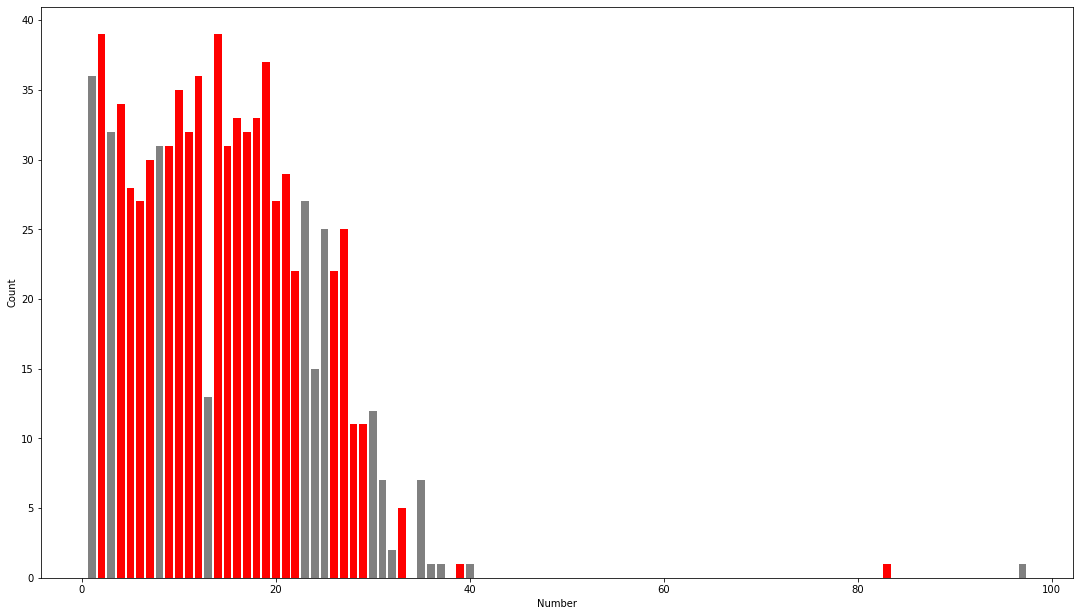

In [76]:
import matplotlib.pyplot as plt
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
nums=list(dfJerseyMens.groupby('number').count()['season'].index)
count=list(dfJerseyMens.groupby('number').count()['season'])
numsW=list(dfJerseyWomens.groupby('number').count()['season'].index)
countW=list(dfJerseyWomens.groupby('number').count()['season'])
curr=list(dfJerseyMens.loc[dfJerseyMens['season'].str.contains('1999-00')]['number'])
for i in range(len(nums)):
    if(nums[i] in curr):
        plt.bar(nums[i],count[i],color='red')
    else:
        plt.bar(nums[i],count[i],color='grey')
#plt.bar(numsW,countW,color='green')
plt.xlabel('Number')
plt.ylabel('Count')
#plt.xticks(nums)
plt.show()

In [45]:
#fig = plt.gcf()
#fig.set_size_inches(18.5, 10.5)

nameDict= dfSkateMens.loc[dfSkate['first']!='—'].groupby('first').count()['name'].to_dict()
#for i in range(len(count)):
#    if(count[i]>1):
#        
#        plt.bar(names[i],count[i],color='red')
#plt.show()
dfSkateMens['decade']=dfSkateMens['career'].str[:4].astype(int).round(-1)

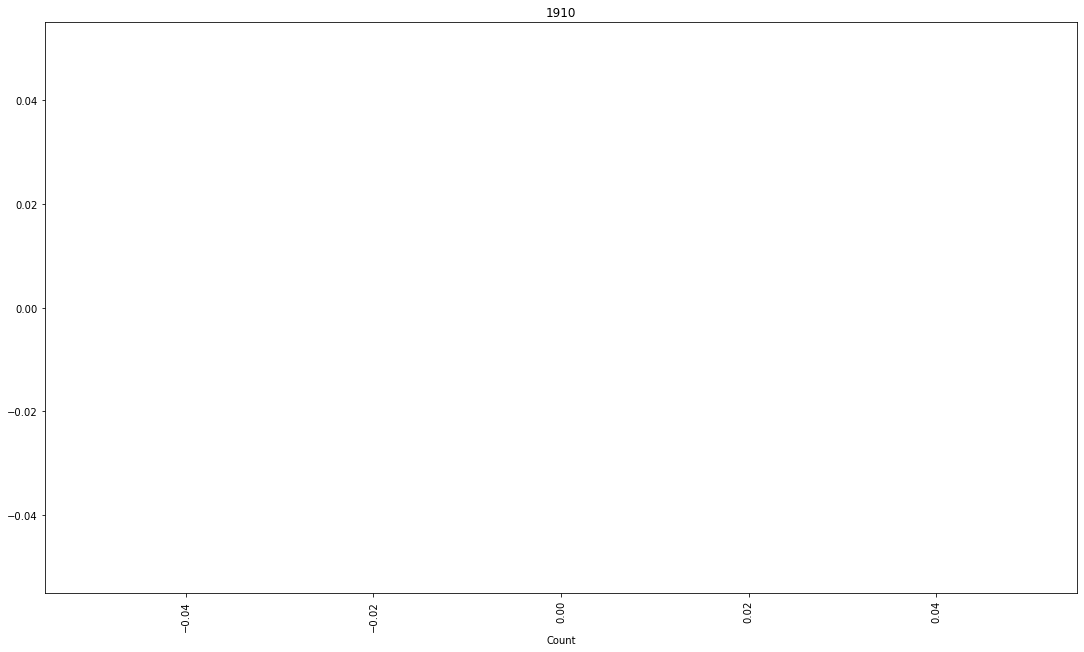

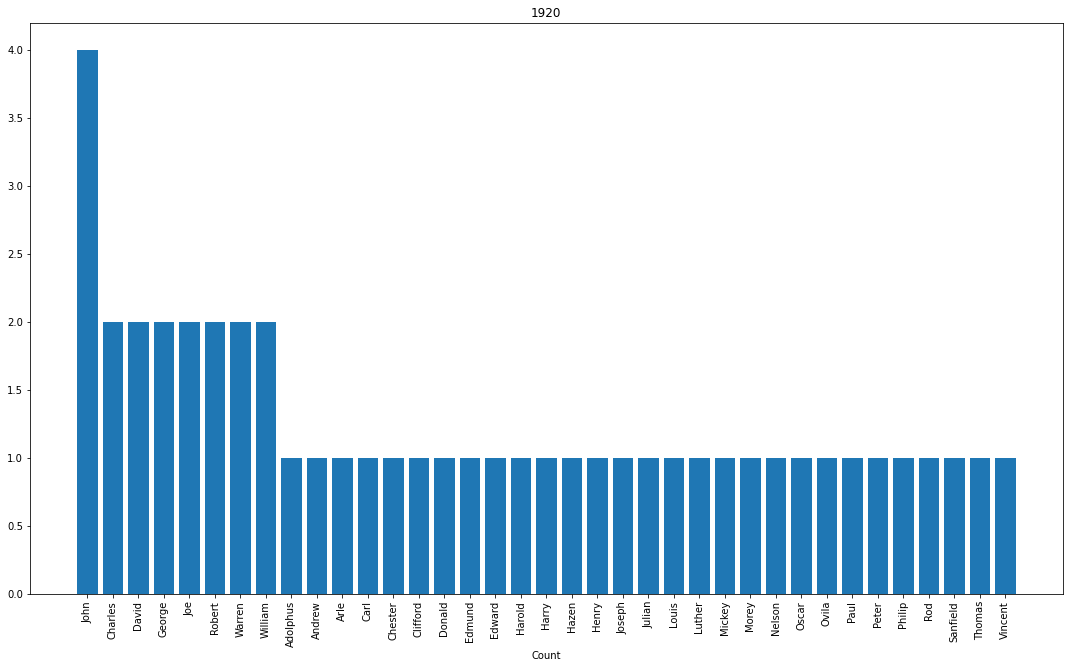

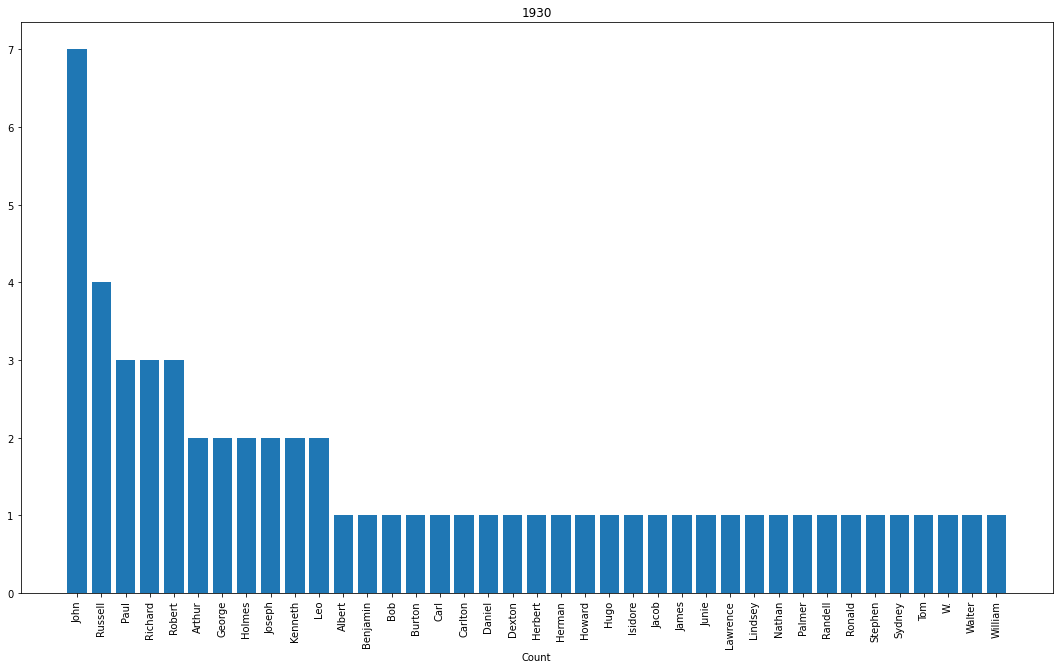

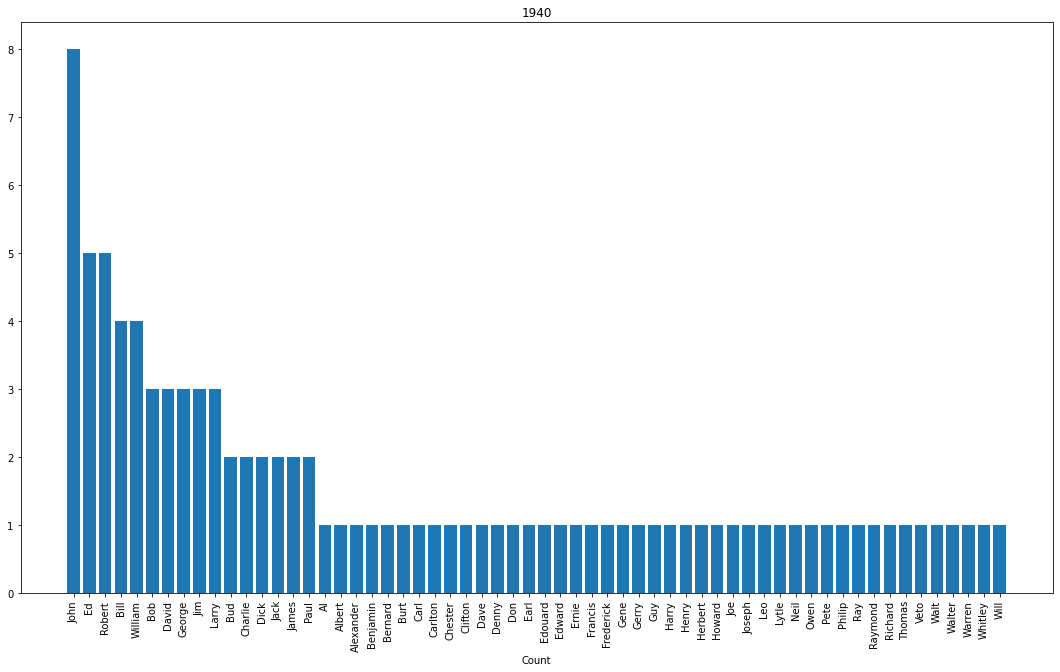

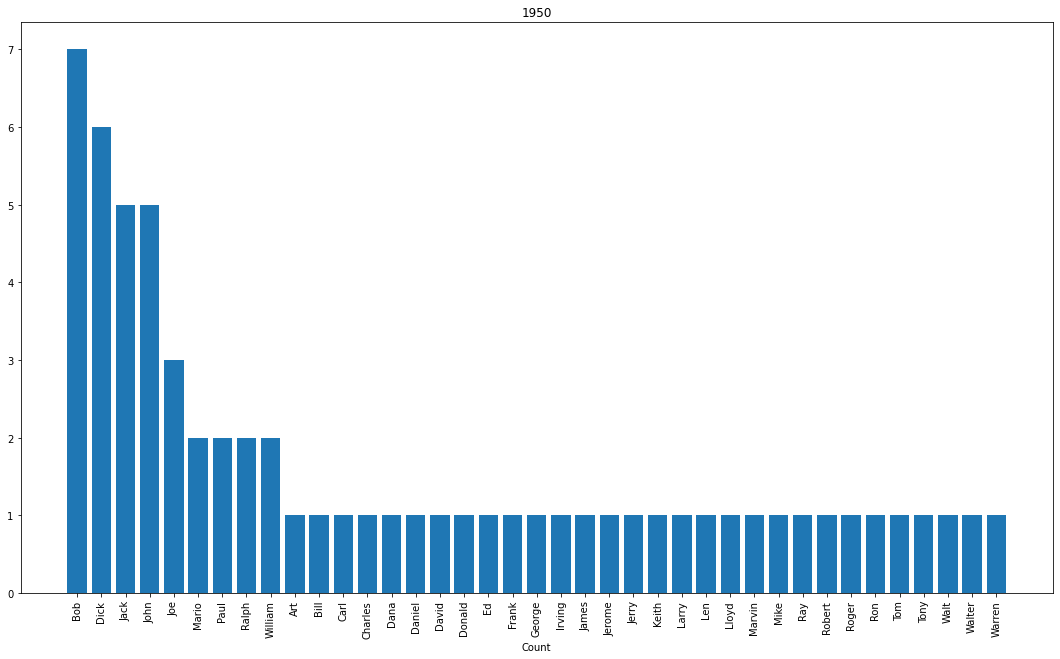

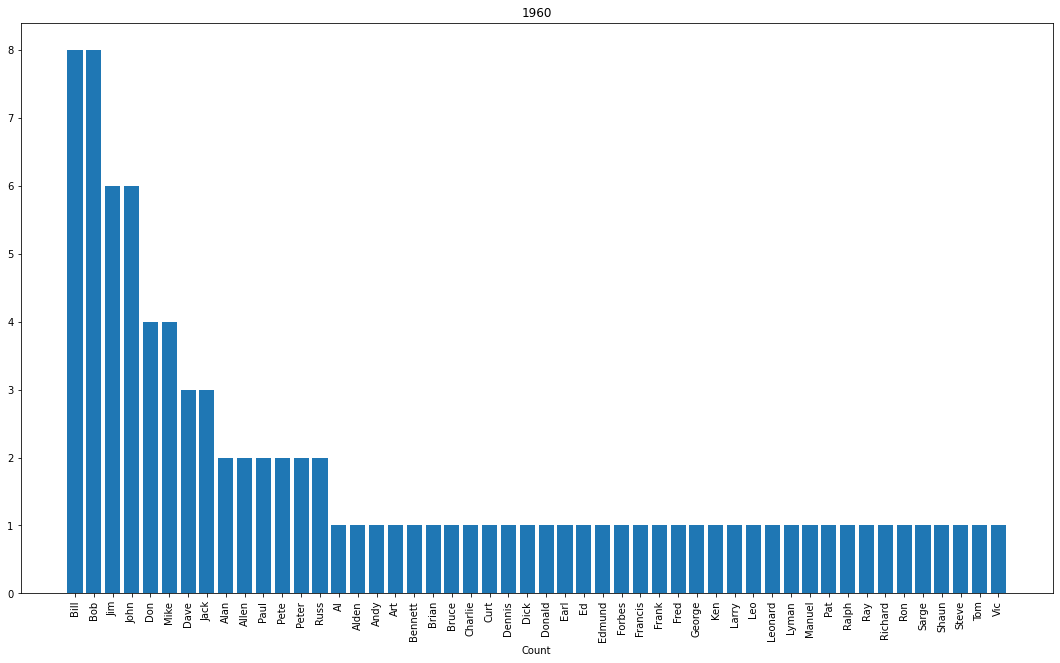

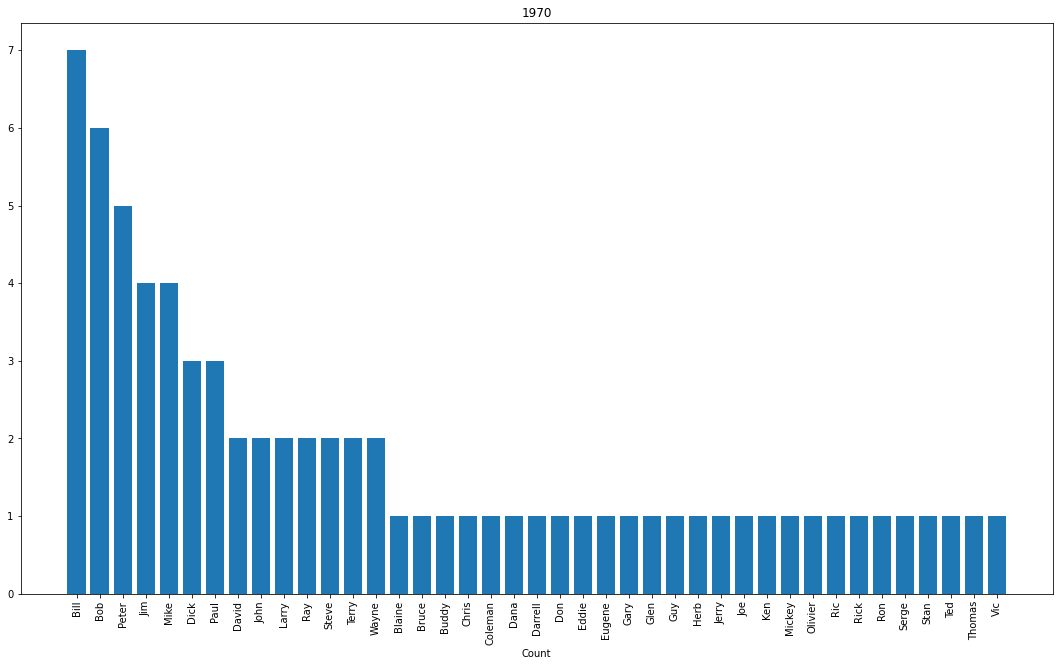

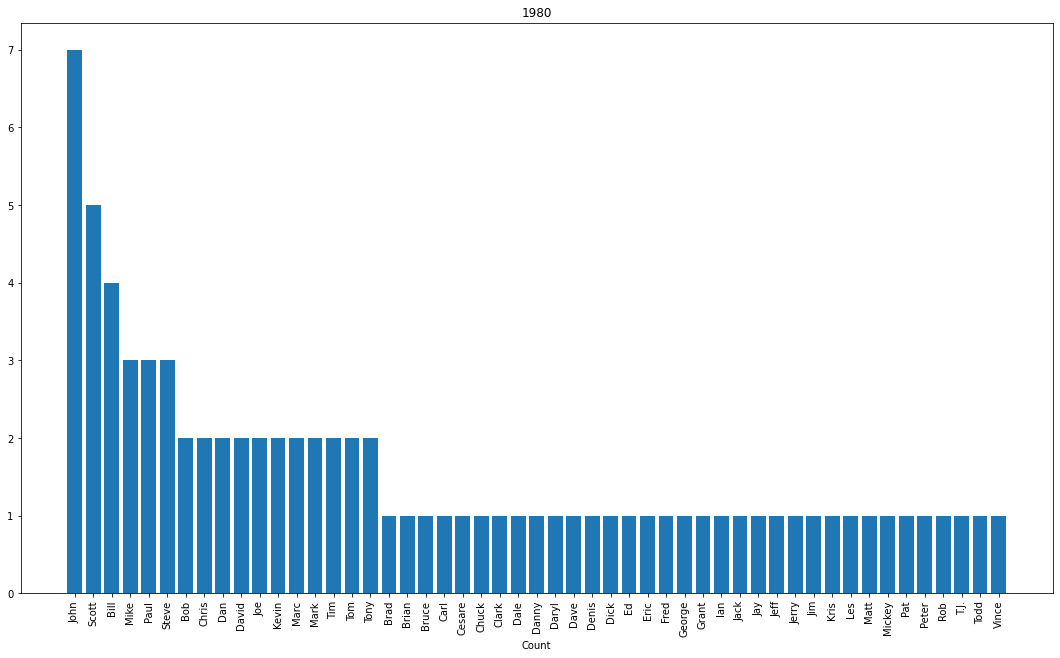

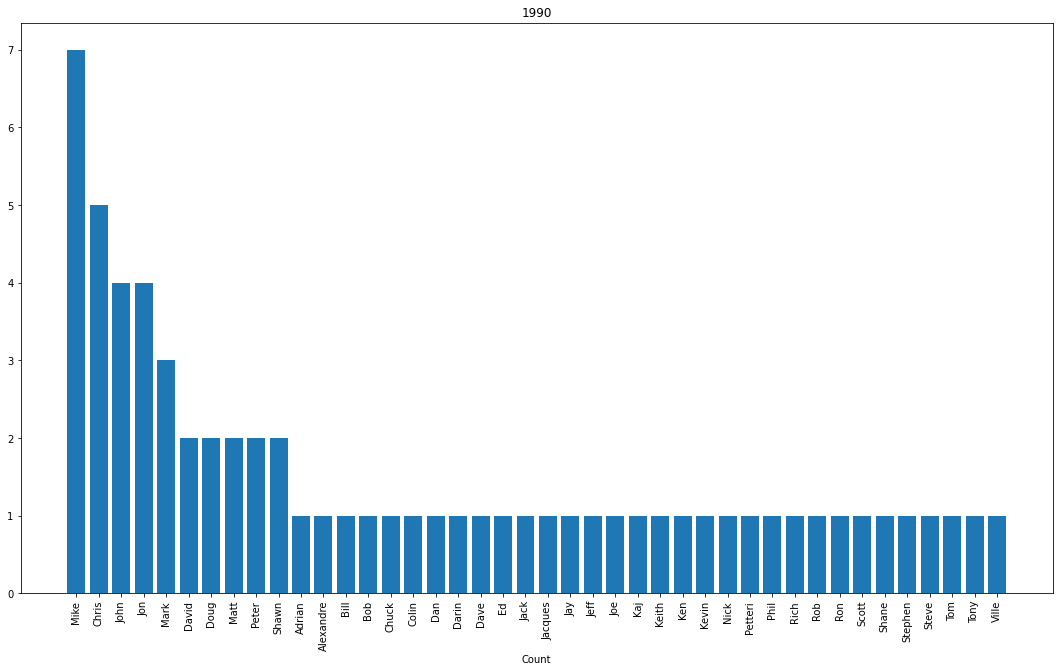

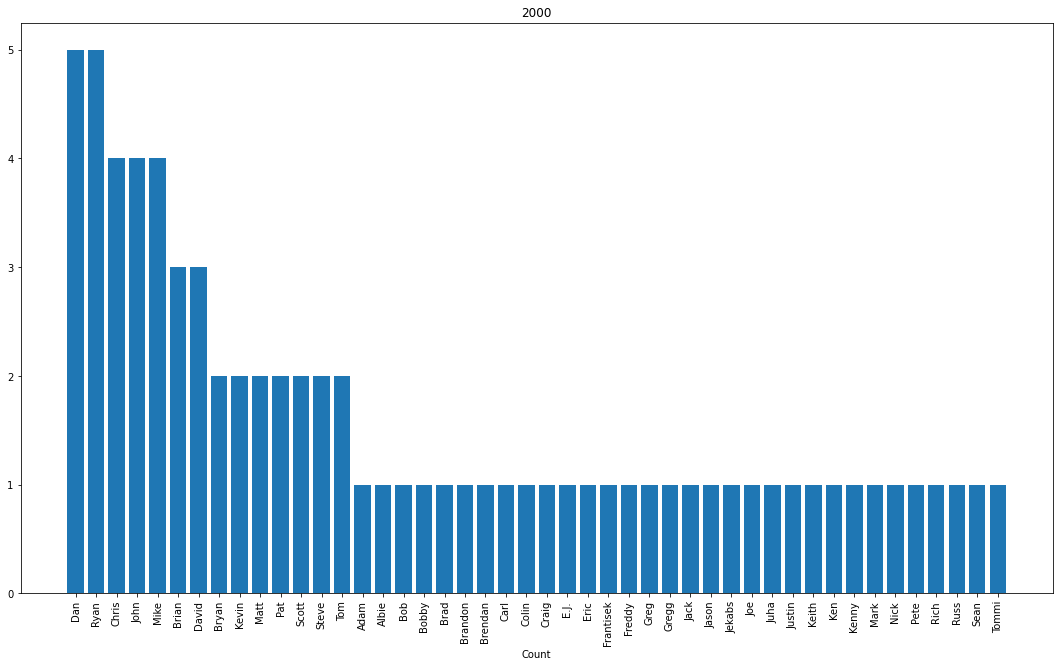

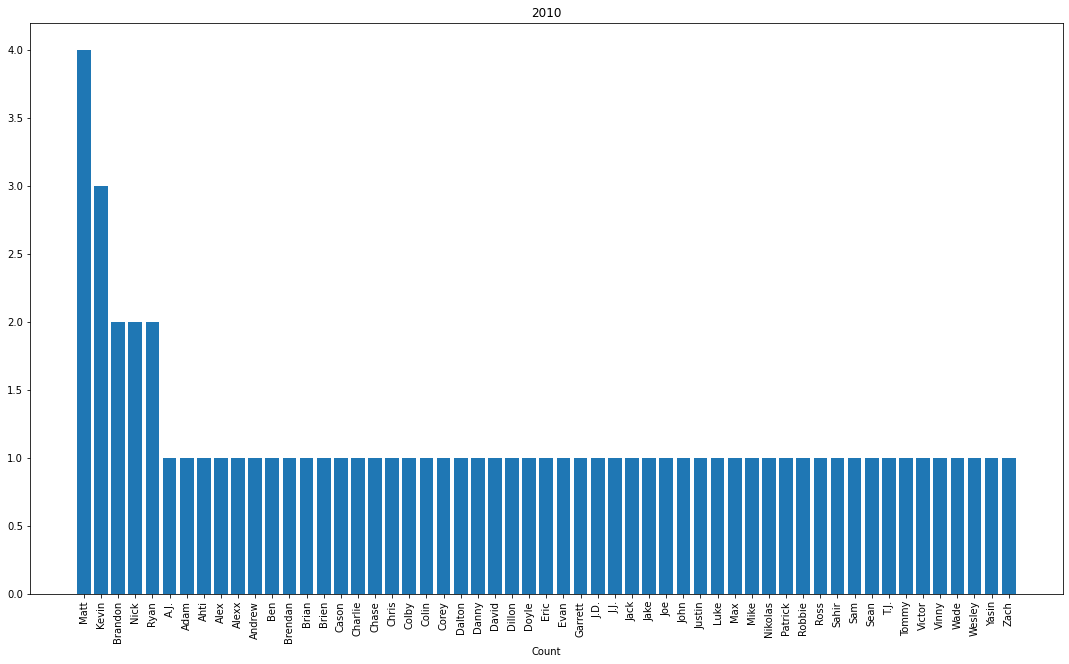

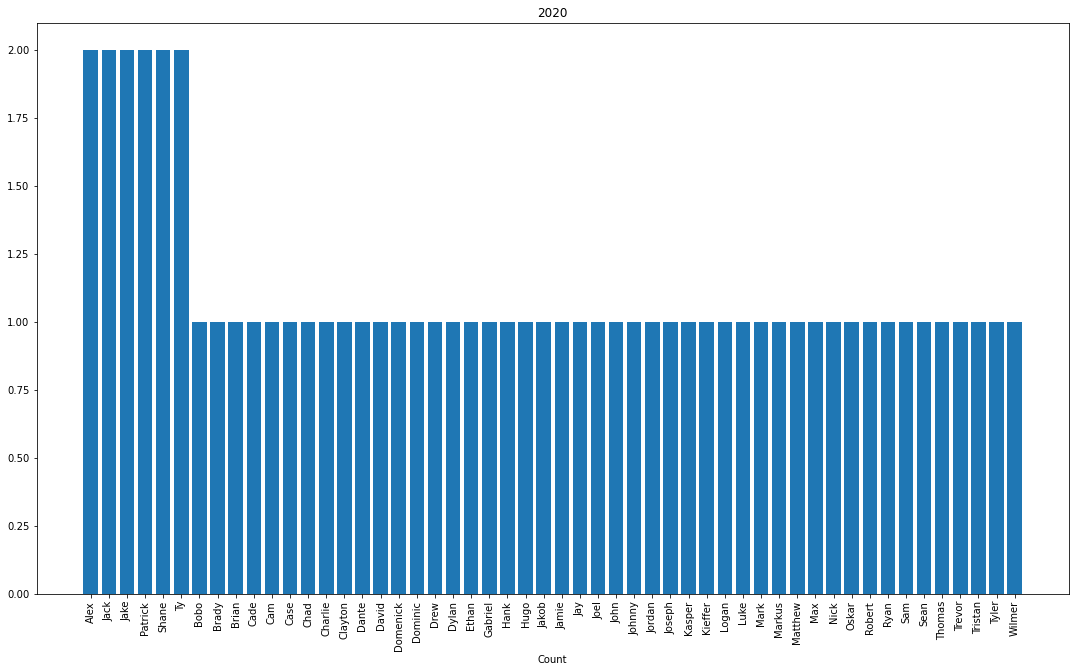

In [95]:
n=0
for decade in range(1910,2030,10):
    fig =  plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    decDict={}
    for i in nameDecDict.keys():
        if(i[0]==decade):
            decDict[i[1]]=nameDecDict[i]
    decDict = dict(sorted(decDict.items(), key=lambda item: item[1],reverse=True))
    plt.bar(decDict.keys(),decDict.values())
    plt.xticks(rotation = 90)
    plt.xlabel('Name')
    plt.xlabel('Count')
    plt.title(decade)
    plt.show()
    n+=1

In [56]:
#team='Northeastern'
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

for team in teams:
    dfGames.loc[(dfGames['opponent']==team) & (dfGames['result']=='W'),'diff']=1
    dfGames.loc[(dfGames['opponent']==team) & (dfGames['result']=='L'),'diff']=-1
    dfGames.loc[(dfGames['opponent']==team) & (dfGames['result']=='T'),'diff']=0
    dfRes=dfGames.loc[(dfGames['opponent']==team) & (dfGames['year']>=2000)  ]
    diffs=list(dfRes['diff'].cumsum())
    year=list(dfRes['date'])


    u[u < 0] = np.nan
    l[l > 0] = np.nan
    z[z == 0] = np.nan

    plt.plot(year,diffs,label=team)
    
#plt.plot(l, color=color)

plt.axhline(y = 0, color = 'k', linestyle = '--')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Lead in Series by Number of Games')
#plt.title('Battle of Comm Ave')
#plt.title('BU vs NU')
plt.legend()
fig.patch.set_facecolor('lightgray')
fig.patch.set_alpha(1)
plt.show()
plt.ion()

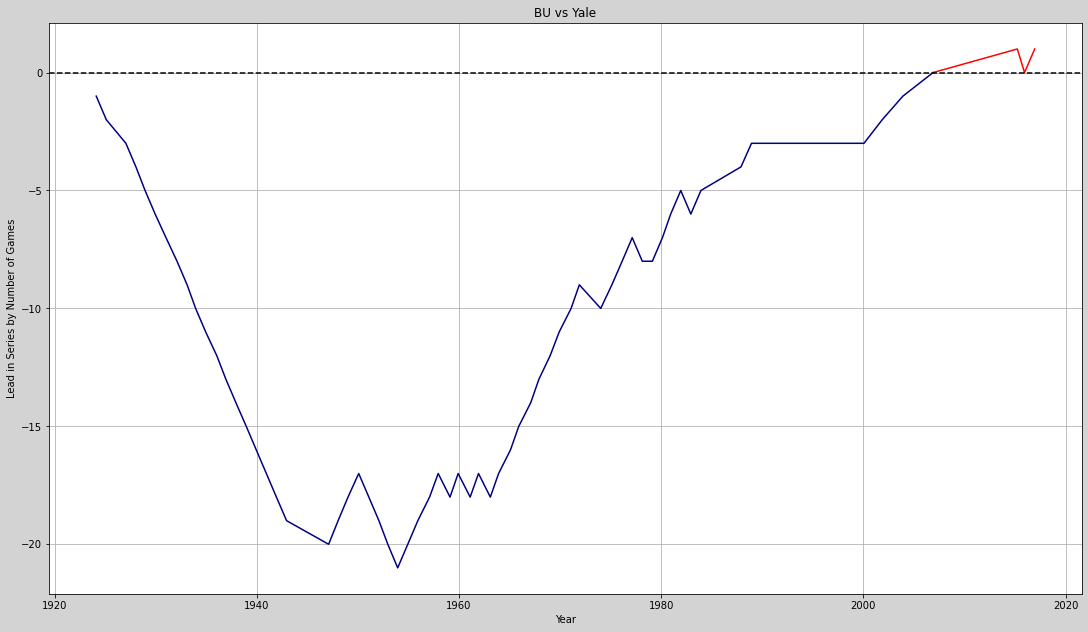

In [36]:
team='Yale'
color='navy'
dfGames.loc[(dfGames['opponent']==team) & (dfGames['result']=='W'),'diff']=1
dfGames.loc[(dfGames['opponent']==team) & (dfGames['result']=='L'),'diff']=-1
dfGames.loc[(dfGames['opponent']==team) & (dfGames['result']=='T'),'diff']=0
dfRes=dfGames.loc[(dfGames['opponent']==team)]
diffs=list(dfRes['diff'].cumsum())
year=list(dfRes['date'])
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
u = np.array(diffs.copy())
l = np.array(diffs.copy())
z = np.array(diffs.copy())

u[u < 0] = np.nan
l[l > 0] = np.nan
z[z == 0] = np.nan

plt.plot(year, u, color='red')
plt.plot(year, l, color=color)

plt.axhline(y = 0, color = 'k', linestyle = '--')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Lead in Series by Number of Games')
#plt.title('Battle of Comm Ave')
plt.title('BU vs Yale')
fig.patch.set_facecolor('lightgray')
fig.patch.set_alpha(1)
plt.show()


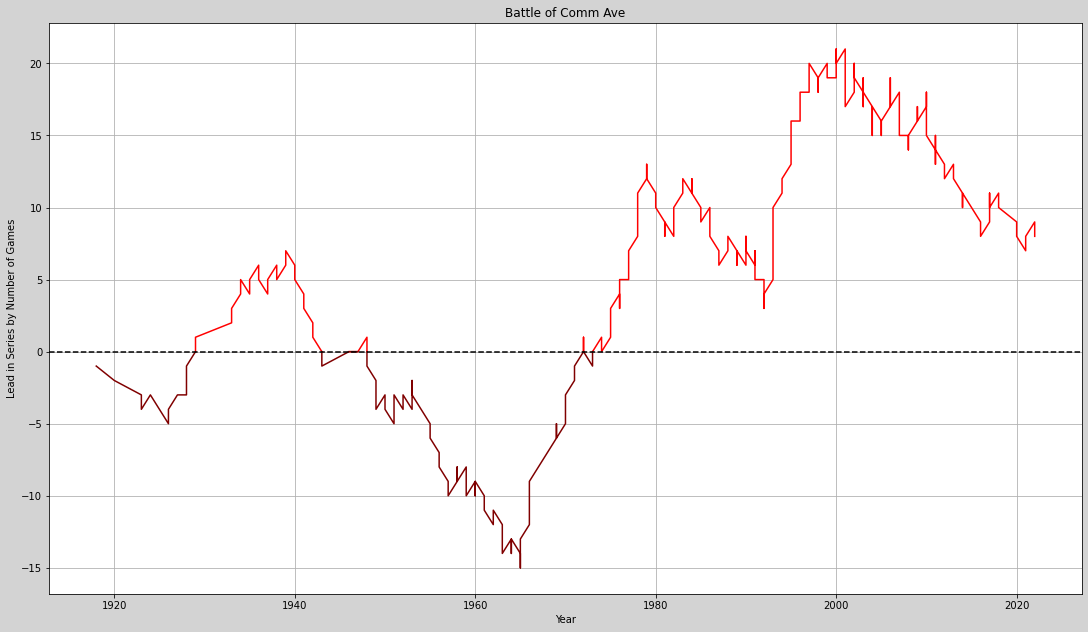

In [31]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
team='Boston College'
dfGames.loc[(dfGames['opponent']==team) & (dfGames['result']=='W'),'diff']=1
dfGames.loc[(dfGames['opponent']==team) & (dfGames['result']=='L'),'diff']=-1
dfGames.loc[(dfGames['opponent']==team) & (dfGames['result']=='T'),'diff']=0
dfRes=dfGames.loc[(dfGames['opponent']==team)]
diffs=list(dfRes['diff'].cumsum())
year=list(dfRes['year'])
u = np.array(diffs.copy())
l = np.array(diffs.copy())
z = np.array(diffs.copy())

u[u < 0] = np.nan
l[l > 0] = np.nan
z[z == 0] = np.nan

plt.plot(year,u, color='red')
plt.plot(year,l, color='maroon')

plt.axhline(y = 0, color = 'k', linestyle = '--')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Lead in Series by Number of Games')
plt.title('Battle of Comm Ave')
fig.patch.set_facecolor('lightgray')
fig.patch.set_alpha(1)
plt.show()

In [70]:
val=dfRes['diff'].cumsum()>0

In [98]:
query="record in hea tourney between 2012 and 2016"
query="#8 in 2017-18"
query=cleanupQuery(query,'bean')
#dfBean={'results':dfBeanpot,'awards':dfBeanpotAwards}
#result=getBeanpotStats(dfBean,query)
#if(result==''):
if(determineQueryType(query)!='player'):
    result=getResults(dfWomensGames,query)  
else:
    playerDfs={}
    playerDfs['careerSkaters']=dfSkate
    playerDfs['careerGoalies']=dfGoalie
    playerDfs['jerseys']=dfJerseyWomens
    playerDfs['seasonleaders']=dfLeadWomens
    playerDfs['seasonSkaters']=dfSeasSkate
    playerDfs['seasonGoalies']=dfSeasGoalie
    result=getPlayerStats(playerDfs,query)
print(result)

Deziray De Sousa


In [25]:
# Get PlayerData
fileName=('PlayerData.txt')
playList=[]
with open(fileName, 'r') as f:
    read_data = f.read()
    rows=read_data.split('\n')
    for i in rows:
        col=i.split('\t')
        pDict={'number':col[0],
              'name':col[1],
              'yr':col[2],
              'pos':col[3],
              'height':col[4],
              'weight':col[5],
              'shot':col[6],
              'yob':col[7],
              'prev':col[8],
              'season':col[9]}
        
        if(pDict['yob']==''):
            pass
        elif(int(pDict['yob'])>20):
            pDict['yob']=int('19'+ (pDict['yob']))
        else:
            pDict['yob']=int('20'+ (pDict['yob']))
        pDict['h_feet'],pDict['h_in']=pDict['height'].split('-')
        pDict['home'],pDict['prevTeam']=pDict['prev'].split('/')
        pDict['prevTeam']=pDict['prevTeam'].strip()
        pDict['hometown'],pDict['homeState']=pDict['home'].split(',')
        pDict['homeState']=pDict['homeState'].strip()
        if(pDict['yob']!=''):
            pDict['age']=int(pDict['season'][:4])-pDict['yob']
        nhlSearch=re.search('(\(.*\))',pDict['name'])
        if(nhlSearch!=None):
            pDict['name']=pDict['name'].replace(nhlSearch.group(1),'').strip()
            pDict['nhl']=nhlSearch.group(1).strip('(').strip(')')
        else:
            pDict['nhl']=''
        del pDict['prev']
        playList.append(pDict)
dfPlayData=pd.DataFrame(playList)
        
f.close()


In [26]:
# Get PlayerData
fileName=('PlayerDataWomens.txt')
playList=[]
with open(fileName, 'r') as f:
    read_data = f.read()
    rows=read_data.split('\n')
    for i in rows:
        col=i.split('\t')
        pDict={'number':col[0],
              'name':col[1],
              'yr':col[2],
              'pos':col[3],
              'height':col[4],
              'shot':col[5],
              'yob':col[6].strip(),
              'prev':col[7],
              'season':col[8]}
        
        if(pDict['yob']=='' or pDict['yob']=='N/A'):
            pass
        elif(int(pDict['yob'])>20):
            pDict['yob']=int('19'+ (pDict['yob']))
        else:
            pDict['yob']=int('20'+ (pDict['yob']))
        pDict['h_feet'],pDict['h_in']=pDict['height'].split('-')
        pDict['home'],pDict['prevTeam']=pDict['prev'].split('/')
        pDict['prevTeam']=pDict['prevTeam'].strip()
        
        pDict['hometown'],pDict['homeState']=pDict['home'].split(',')
        pDict['homeState']=pDict['homeState'].strip()
        if(pDict['yob']!='' and pDict['yob']!='N/A'):
            pDict['age']=int(pDict['season'][:4])-pDict['yob']
        nhlSearch=re.search('(\(.*\))',pDict['name'])
        if(nhlSearch!=None):
            pDict['name']=pDict['name'].replace(nhlSearch.group(1),'').strip()
            pDict['nhl']=nhlSearch.group(1).strip('(').strip(')')
        else:
            pDict['nhl']=''
        del pDict['prev']
        playList.append(pDict)
dfPlayDataWomens=pd.DataFrame(playList)
        
f.close()

In [24]:
dfBeanpot['SoS']=dfBeanpot['champion'].ne(dfBeanpot['champion'].shift())
dfBeanpot['streak_id']=dfBeanpot.SoS.cumsum()
dfBeanpot['streak_counter'] = dfBeanpot.groupby('streak_id').cumcount() + 1
dfRes=dfBeanpot.sort_values('streak_counter',ascending=False)
streak=[]
for i in sorted(dfRes['streak_id'].unique()):
    streakLen=dfRes.loc[dfRes['streak_id']==i].max()['streak_counter']
    streakOwner=dfRes.loc[dfRes['streak_id']==i].max()['champion']
    startYear=dfRes.loc[dfRes['streak_id']==i].min()['year']
    endYear=dfRes.loc[dfRes['streak_id']==i].max()['year']
    if(streakLen>1):
        streak.append("{} {} {},{}".format(streakLen,streakOwner,startYear,endYear))
streak=(sorted(streak,reverse=True)) 
for i in streak:
    print(i)

6 Boston University 1995,2000
5 Boston College 2010,2014
4 Boston University 1970,1973
3 Northeastern 2018,2020
3 Boston University 2005,2007
3 Boston University 1990,1992
3 Boston University 1966,1968
3 Boston College 1963,1965
2 Northeastern 1984,1985
2 Boston University 2002,2003
2 Boston University 1986,1987
2 Boston University 1978,1979
2 Boston College 1956,1957


In [30]:
team='Yale'
dfRes=dfGames.loc[dfGames['opponent']==team]
dfRes['SoS']=dfRes['result'].ne(dfRes['result'].shift())
dfRes['streak_id']=dfRes.SoS.cumsum()
dfRes['streak_counter'] = dfRes.groupby('streak_id').cumcount() + 1
dfRes=dfRes.sort_values('streak_counter',ascending=False)
streak=[]
for i in sorted(dfRes['streak_id'].unique()):
    streakLen=dfRes.loc[dfRes['streak_id']==i,'streak_counter'].max()
    streakOwner=dfRes.loc[dfRes['streak_id']==i,'result'].max()
    if(streakOwner=='W'):
        streakOwner='BU'
    elif(streakOwner=='L'):
        streakOwner=team
    else:
        streakOwner='Tie'
    startDate=dfRes.loc[dfRes['streak_id']==i,'date'].min()
    endDate=dfRes.loc[dfRes['streak_id']==i,'date'].max()
    if(streakLen>1):
        print("{} {} {},{}".format(streakLen,streakOwner,str(startDate)[:10],str(endDate)[:10]))
    else:
        print("{} {} {}".format(streakLen,streakOwner,str(startDate)[:10]))

20 Yale 1924-02-13,1947-02-08
3 BU 1948-01-17,1950-01-30
4 Yale 1951-01-31,1953-12-08
4 BU 1954-12-08,1957-12-11
1 Yale 1959-02-11
1 BU 1959-12-02
1 Yale 1961-02-08
1 BU 1961-12-06
1 Yale 1963-02-06
9 BU 1963-12-02,1971-11-27
1 Yale 1974-01-09
3 BU 1975-02-15,1977-02-19
1 Yale 1978-02-18
1 Tie 1979-02-17
3 BU 1980-02-16,1981-12-09
1 Yale 1982-12-08
3 BU 1983-12-07,1988-12-07
2 Tie 1996-12-06,2000-01-23
4 BU 2001-11-13,2015-03-27
1 Yale 2015-12-11
1 BU 2016-12-13


<ipython-input-30-d47ca3684bc9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfRes['SoS']=dfRes['result'].ne(dfRes['result'].shift())
<ipython-input-30-d47ca3684bc9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfRes['streak_id']=dfRes.SoS.cumsum()
<ipython-input-30-d47ca3684bc9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [85]:
dfGames.loc[dfGames['opponent']=='Boston College']

,date,result,ot,arena,opponent,gameType,tourney,scoreline,location,coach,...,season,note,seasonType,month,day,year,BUScore,OppoScore,GD,dow
0,1918-02-06,L,None,Boston Arena,Boston College,Non-Conference,None,1-3,Home,Edgar Burkhardt,...,1917-18,,Regular Season,2,6,1918,1,3,2,2
2,1920-02-04,L,None,University Rink,Boston College,Non-Conference,None,0-9,Away,Harold Stuart,...,1919-20,,Regular Season,2,4,1920,0,9,9,2
7,1923-01-26,L,3ot,Boston Arena,Boston College,Non-Conference,None,2-3,Home,John O'Hare,...,1922-23,,Regular Season,1,26,1923,2,3,1,4
8,1923-02-07,L,None,Boston Arena,Boston College,Non-Conference,None,2-7,Home,John O'Hare,...,1922-23,,Regular Season,2,7,1923,2,7,5,2
22,1924-12-23,W,None,Boston Arena,Boston College,Non-Conference,None,1-0,Home,George Gaw,...,1924-25,,Regular Season,12,23,1924,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2751,2021-02-05,L,ot,Conte Forum,Boston College,Conference,None,3-4,Away,Albie O'Connell,...,2020-21,,Regular Season,2,5,2021,3,4,1,4
2752,2021-02-06,W,None,Walter Brown Arena,Boston College,Conference,None,3-1,Home,Albie O'Connell,...,2020-21,,Regular Season,2,6,2021,3,1,2,5
2779,2021-12-10,T,ot,Agganis Arena,Boston College,Conference,None,3-3,Home,Albie O'Connell,...,2021-22,,Regular Season,12,10,2021,3,3,0,4
2793,2022-02-26,W,None,Agganis Arena,Boston College,Conference,None,6-3,Home,Albie O'Connell,...,2021-22,,Regular Season,2,26,2022,6,3,3,5


In [31]:
dfBeanpotAwards['champion']=dfBeanpot['champion']

In [70]:
dfBeanpotAwards.loc[(dfBeanpotAwards['mvpSchool']!=dfBeanpotAwards['champion']) & (dfBeanpotAwards['ebSchool']!='')]

,year,mvpName,mvpPos,mvpSchool,ebName,ebSchool,ebSaves,ebGA,ebSV%,ebGAA,champion
51,2004,Sean Fields,G,Boston University,Sean Fields,Boston University,85,4,0.955,1.9,Boston College
60,2013,Kevin Roy,F,Northeastern,Parker Milner,Boston College,39,4,0.907,2,Boston College
63,2016,Sean Maguire,G,Boston University,Sean Maguire,Boston University,65,2,0.97,0.98,Boston College


In [24]:
### Current Team ###

In [105]:
def updateCurrentSeasonStats():
    currSeason='2021-22'
    url = "https://goterriers.com/sports/mens-ice-hockey/stats?path=mhockey"
    #print(url)
    f=urllib.request.urlopen(url)
    html = f.read()
    f.close()
    soup = BeautifulSoup(html, 'html.parser')
    head=soup.find('h1',{'class':'no-print'})
    if(currSeason not in head.get_text()):
        pass
    else:
        curSkate=soup.find('section',{'id':'individual-overall-skaters'})
        rows=curSkate.find_all('tr')
        currSkaters=[]
        for i in rows:
            col=i.find_all('td')
            name=i.find('span')
            if(name!=None):
                lastName,firstName=name.get_text().split(', ')
                skateDict={'number':int(col[0].get_text()),
                           'last':lastName,
                           'first':firstName,
                           'name':firstName+' '+lastName,
                            'gp':int(col[1].get_text()),
                            'goals':int(col[2].get_text()),
                            'assists':int(col[3].get_text()),
                            'pts':int(col[4].get_text()),
                            'pens':col[16].get_text().replace('-','/'),
                            'season':currSeason}
                currSkaters.append(skateDict)
        dfCurSkate=pd.DataFrame(currSkaters)



        curGoals=soup.find('section',{'id':'individual-overall-goaltenders'})
        rows=curGoals.find_all('tr')
        currGoalies=[]
        for i in rows:
            col=i.find_all('td')
            name=i.find('span')

            if(name!=None):
                lastName,firstName=name.get_text().split(',')
                goalDict={'number':int(col[0].get_text()),
                           'last':lastName,
                           'first':firstName,
                           'name':firstName+' '+lastName,
                            'gp':int(col[1].get_text().split('-')[0]),
                            'mins':col[2].get_text(),
                            'ga':col[3].get_text(),
                            'gaa':col[4].get_text(),
                            'saves':col[8].get_text(),
                            'sv%':col[9].get_text(),
                            'W':col[10].get_text(),
                            'L':col[11].get_text(),
                            'T':col[12].get_text(),
                            'SO':col[13].get_text(),
                            'season':currSeason}
                currGoalies.append(goalDict)

        dfCurGoal=pd.DataFrame(currGoalies)
        return dfCurSkate,dfCurGoal

In [106]:
dfCurSkate,dfCurGoal=updateCurrentSeasonStats()

In [ ]:
'''fileName=('SeasonSkaterStats.txt')
with open(fileName, 'a', encoding='utf-8') as f:
    for i in dfPlayData.to_string(index=False,header=False).split('\n'):
    row=list(filter(None,i.split('  ')))
    print("\t".join(row),file=f)
f.close()
'''

In [109]:
dfSeasTest=dfSeasSkateMens.copy(deep=True)

In [36]:
dfPlayData[['name','home']].loc[dfPlayData['home'].str.contains('Medford')].drop_duplicates()

,name,home
236,Anthony Moccia,"Medford, Massachusetts"


In [121]:
dfCurSkate.loc[dfCurSkate['name']=='Jack Page','goals']=2

In [122]:
season='2021-22'
for i,row in dfCurSkate.iterrows():
    for stat in ['gp','goals','assists','pts','pens']:
        dfSeasTest.loc[(dfSeasTest['season']==season) & (dfSeasTest['name']==row['name']),stat]=row[stat]
    

In [115]:
dfSeasTest.loc[(dfSeasTest['season']==season) & (dfSeasTest['name']==row['name'])]

,number,name,pos,yr,gp,goals,assists,pts,pens,season,year
517,19,Jack Page,D,SO,1,0,0,0,0/0,2021-22,2022


In [123]:
dfSeasTest.loc[dfSeasTest['season']=='2021-22']

,number,name,pos,yr,gp,goals,assists,pts,pens,season,year
487,23,Domenick Fensore,D,JR,35,5,26,31,4/8,2021-22,2022
488,32,Wilmer Skoog,F,JR,35,15,15,30,10/20,2021-22,2022
489,16,Robert Mastrosimone,F,JR,34,11,14,25,10/28,2021-22,2022
490,18,Jay O'Brien,F,JR,24,10,12,22,15/38,2021-22,2022
491,37,Matt Brown,F,JR,24,7,10,17,2/4,2021-22,2022
492,28,Ethan Phillips,F,JR,28,6,11,17,6/12,2021-22,2022
493,13,Dylan Peterson,F,SO,29,10,6,16,9/18,2021-22,2022
494,4,Ty Gallagher,D,FR,34,5,11,16,12/35,2021-22,2022
495,2,Case McCarthy,D,JR,26,5,9,14,6/20,2021-22,2022
496,21,Max Kaufman,F,GR,34,6,5,11,6/12,2021-22,2022
